In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import keras
from functools import partial

In [4]:
import keras.models as km
import keras.layers as kl
import keras.activations as ka
import keras.layers.advanced_activations as kla

In [5]:
import keras.backend as K

In [6]:
#from tensorflow.python.client import device_lib

In [7]:
from IPython import display
import time

In [6]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2436406822065410352, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14615607564618076357
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 806596212033273996
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5453577826141622531
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 i

In [8]:
from keras.layers.merge import _Merge

In [9]:
class LayerNormalization(kl.Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
        See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        self.input_spec = keras.engine.InputSpec(shape=input_shape)
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization, self).build(input_shape)

    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
            
        return outputs

In [10]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [11]:
def batchnorm(center=True, momentum=0.8):
    return kl.BatchNormalization(center=center, momentum=momentum)

def clayer(nfeatures, kernel_size=(3, 3), strides=(1,1), use_bias=True, **kwargs):
    
    return kl.Conv2D(nfeatures,
                     kernel_size=kernel_size,strides=strides, 
                     use_bias=use_bias, padding='same', **kwargs)

def NonLinearity(activation='relu'):
    
    if activation == 'relu':
        return kl.Activation('relu')
    elif activation == 'lrelu':
        return kla.LeakyReLU(alpha=0.2)

def ResBlock(x, nf, dropout=None, norm='batch', activation='relu', **kwargs):
    
    shortcut = x
    x = clayer(nf, **kwargs)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    
    return x

def DownBlock(x, nf, dropout=None, norm=None, activation='lrelu', **kwargs):
    """
    This reduces the dimensionality using convolutions.
    """
    
    shortcut = clayer(nf, kernel_size=(1,1), strides=(2,2), **kwargs)(x)
    x = clayer(nf, kernel_size=(2,2), strides=(2,2), **kwargs)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
        
    return x

In [12]:
def get_critic(input_shape, base_features=32, norm=None):
    """
    A simple discriminator.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv2D(base_features, (3,3), padding='same', strides=2)(input_state)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*2, (3,3), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*4, (3,3), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*8, (3,3), padding='same', strides=1)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
        
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Dropout(0.25)(x)
    x = kl.Flatten()(x)
    #Linear activation for the critic
    x = kl.Dense(units=1)(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

def get_critic2(input_shape, base_features=32, norm=None):
    """
    A less simple critic discriminator.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv2D(base_features, (7,7), padding='same', strides=2)(input_state)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*2, (5,5), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*4, (3,3), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*8, (1,1), padding='same', strides=1)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Dropout(0.25)(x)
    x = kl.Flatten()(x)
    #Linear activation for the critic
    x = kl.Dense(units=1)(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model


def get_critic3(input_shape, nlevels=3, base_features=32, norm=None, activation='lrelu', dropout=None, **kwargs):
    """
    Returns a 2D CNN critic based on the ResNet model.
    Parameters
    ---------
    input_shape : np.array((3))
        Specifies the size of the input data, usually (weight, height, 1)
    
    nlevels : int (optional)
        The number of times (-1) to downsample the resolution
        Default 4.
    base_features: int (optional)
        The number of features the input layer should learn.
        Default 32.
    Returns
    -------
    model :
        The keras model.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv2D(base_features, (7,7), use_bias=False, padding='same', **kwargs)(input_state)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity()(x)

    for level in range(nlevels):
        
        if level != 0:
            # This layer ups the number of features while downsampling spatially
            x = DownBlock(x, base_features*2**level, dropout=dropout, 
                          norm=norm, activation=activation, **kwargs)
    
        x = ResBlock(x, base_features*2**level, dropout=dropout, 
                     norm=norm, activation=activation, **kwargs)
        x = ResBlock(x, base_features*2**level, dropout=dropout, 
                     norm=norm, activation=activation, **kwargs)
        #if level in [1, 2]:
        #    x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)

    x = kl.GlobalAvgPool2D()(x)
    x = kl.Dropout(0.25)(x)
    #x = kl.Flatten()(x)
    x = kl.Dense(1)(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model


In [13]:
def get_discriminator2(input_shape, base_features=32):
    """
    A simple discriminator.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv2D(base_features, (7,7), padding='same', strides=2)(input_state)
    x = kl.BatchNormalization(momentum=0.8)(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*2, (5,5), padding='same', strides=2)(x)
    x = kl.BatchNormalization(momentum=0.8)(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*4, (3,3), padding='same', strides=2)(x)
    x = kl.BatchNormalization(momentum=0.8)(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv2D(base_features*8, (1,1), padding='same', strides=1)(x)
    x = kl.BatchNormalization(momentum=0.8)(x)
    x = kla.LeakyReLU(alpha=0.2)(x)

    x = kl.Dropout(0.25)(x)
    x = kl.Flatten()(x)
    #Sigmoid goes with binary crossentropy
    x = kl.Dense(units=1, activation='sigmoid')(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model


def get_discriminator(input_shape, nclasses=1, nlevels=4, base_features=32, dropout=None, **kwargs):
    """
    Returns a 2D CNN based on the ResNet model.
    Parameters
    ---------
    input_shape : np.array((3))
        Specifies the size of the input data, usually (weight, height, 1)
    
    nlevels : int (optional)
        The number of times (-1) to downsample the resolution
        Default 4.
    base_features: int (optional)
        The number of features the input layer should learn.
        Default 64.
    Returns
    -------
    model :
        The keras model.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv2D(base_features, (7,7), use_bias=False, padding='same', **kwargs)(input_state)
    x = kl.BatchNormalization(center=False)(x)
    x = NonLinearity()(x)

    for level in range(nlevels):
        
        if level != 0:
            # This layer ups the number of features while downsampling spatially
            x = DownBlock(x, base_features*2**level, dropout=dropout, **kwargs)
    
        x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)
        x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)
        #if level in [1, 2]:
        #    x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)

    #x = kl.GlobalAvgPool2D()(x)
    x = kl.Dropout(0.25)(x)
    x = kl.Flatten()(x)
    #x = kl.Dense(units=256, activation='relu')(x)
    
    #Sigmoid goes with binary crossentropy
    x = kl.Dense(units=nclasses, activation='sigmoid')(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

In [12]:
disc = get_discriminator2(input_shape=img_shape)
disc.summary()

NameError: name 'img_shape' is not defined

In [14]:
#Build Generator which takes noise as input
#model.add(Dense(256, input_dim=latent_dim))

def UpBlock(x, nf, dropout=None, **kwargs):
    """
    This increases the dimensionality using transposed convolutions.
    """
    
    shortcut = kl.Conv2DTranspose(nf, kernel_size=(1,1), strides=(2,2), **kwargs)(x)
    
    x = kl.Conv2DTranspose(nf, kernel_size=(3, 3), strides=(2,2), padding='same')(x)
    x = batchnorm()(x)
    x = NonLinearity()(x)
    
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = batchnorm()(x)
    x = NonLinearity()(x)
    
    return x

def OutputBlock(x, nf, activation='tanh', **kwargs):
    
    shortcut = x
    x = clayer(nf, **kwargs)(x)
    x = batchnorm()(x)
    x = NonLinearity()(x)
    x = clayer(1, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = batchnorm()(x)
    x = kl.Activation(activation)(x)
    
    return x

def get_generator(input_shape, image_shape, nlevels=4, base_features=32, dropout=None, **kwargs):
    
    """
    Takes in noise and returns an image
    """

    # Get the input and reshape it into an image of the right shape.
    input_state = kl.Input(shape=input_shape)
    
    ii_width = image_shape[0]//2**nlevels
    ii_height = image_shape[1]//2**nlevels
    
    x = kl.Dense(units=ii_width*ii_height*base_features)(input_state)
    x = NonLinearity()(x)
    x = kl.Reshape((ii_width, ii_height, base_features))(x)
    
    #x = ResBlock(x, base_features, dropout=dropout, **kwargs)
    #x = ResBlock(x, base_features, dropout=dropout, **kwargs)

    for level in range(nlevels):
        
        #Reduce nfeatures by half
        x = UpBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
    
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
            
    x = clayer(1)(x)
        
    # This last layer is linear
    #x = kl.Conv2D(1, kernel_size=(7,7), strides=(1,1), padding='same', activation='tanh')(x)
    #x = kl.Conv2D(1, kernel_size=(1,1), strides=(1,1), padding='same')(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

In [53]:
gen = get_generator(input_shape=(latent_dim,), image_shape=(img_rows, img_cols), nlevels=3)
gen.summary()

8 8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2048)         206848      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 8, 8, 32)     0           dense_3[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 16, 16, 16)   4624        reshape_3[0][0]                  
__________________________________________________________________________________________________
batch_

## Build and Compile

In [15]:
model=None
K.clear_session()

In [16]:
# Define some metadata
img_rows = 64
img_cols = 64
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

### Standard GAN

In [39]:
#Ok let's build and compile everything
#optimizer = Adam(1e-5, 0.5)
optimizer = Adam(1e-4, 0.8, 0.99)

# Build and compile the discriminator
discriminator = get_discriminator(input_shape=img_shape, nlevels=4, base_features=16)
#discriminator = get_discriminator(input_shape=img_shape, base_features=32)
#discriminator = get_discriminator2(input_shape=img_shape, base_features=32)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = get_generator(input_shape=(latent_dim,), base_features=16*2**4,
                          image_shape=(img_rows, img_cols), nlevels=4)

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
#combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

### Wasserstein GAN

In [17]:
#Ok let's build and compile everything
#self.n_critic = 5
#optimizer = RMSprop(lr=0.00005)
##optimizer = RMSprop(lr=0.00005, decay=5e-5)
#optimizer = RMSprop(lr=0.00005)

optimizer = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9, decay=1e-5)
#optimizer = Adam(lr=1e-4, beta_1=0.5, beta_2=0.999)
#optimizer = Adam(lr=2e-4, beta_1=0., beta_2=0.9, decay=1e-5)

# Build the critic
#critic = get_critic(input_shape=img_shape, base_features=32, norm=None)
#critic = get_critic2(input_shape=img_shape, base_features=32, norm=None)
critic = get_critic3(input_shape=img_shape, base_features=16, nlevels=2, norm='layer', activation='lrelu')

# Build the generator
generator = get_generator(input_shape=(latent_dim,), base_features=16*2**3,
                          image_shape=(img_rows, img_cols), nlevels=3)

#-------------------------------
# Construct Computational Graph
#       for the Critic
#-------------------------------

# Freeze generator's layers while training critic
generator.trainable = False

# Image input (real sample)
real_img = Input(shape=img_shape)

# Noise input
z_disc = Input(shape=(latent_dim,))
# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

# Discriminator determines validity of the real and fake images
fake = critic(fake_img)
valid = critic(real_img)

# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage()([real_img, fake_img])
# Determine validity of weighted sample
validity_interpolated = critic(interpolated_img)

# Use Python partial to provide loss function with additional
# 'averaged_samples' argument
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

critic_model = Model(inputs=[real_img, z_disc],
                     outputs=[valid, fake, validity_interpolated])
critic_model.compile(loss=[wasserstein_loss,
                           wasserstein_loss,
                           partial_gp_loss],
                     optimizer=optimizer,
                     loss_weights=[1, 1, 10])
#-------------------------------
# Construct Computational Graph
#         for Generator
#-------------------------------

# For the generator we freeze the critic's layers
critic.trainable = False
generator.trainable = True

# Sampled noise for input to generator
z_gen = Input(shape=(latent_dim,))
# Generate images based of noise
img = generator(z_gen)
# Discriminator determines validity
valid = critic(img)
# Defines generator model
generator_model = Model(z_gen, valid)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)

In [19]:
def grf_2d(A, alpha, image_shape=(64, 64), seed=None, normalize=True):
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    grf = np.random.normal(size=image_shape)
    
    kx = np.fft.fftfreq(image_shape[0])
    ky = np.fft.fftfreq(image_shape[1])
    kk = np.sqrt(kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2)
    
    kk[0, 0] = A
    pk = A*kk**alpha
    
    grf = np.fft.ifft2(np.fft.fft2(grf)*np.sqrt(pk)).real
    
    if normalize:
        grf = (grf - np.mean(grf))/np.std(grf)
    
    return grf

def grf_3d(A, alpha, image_shape=(64, 64, 64), seed=None, normalize=True):
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    grf = np.random.normal(size=image_shape)
    
    kx = np.fft.fftfreq(image_shape[0])
    ky = np.fft.fftfreq(image_shape[1])
    kz = np.fft.fftfreq(image_shape[2])
    kk = np.sqrt(kx[:, np.newaxis, np.newaxis]**2 
                 + ky[np.newaxis, :, np.newaxis]**2 
                 + kz[np.newaxis, np.newaxis, :]**2)
    
    kk[0, 0, 0] = A
    pk = A*kk**alpha
    
    grf = np.fft.ifftn(np.fft.fftn(grf)*np.sqrt(pk)).real
    
    if normalize:
        grf = (grf - np.mean(grf))/np.std(grf)
    
    return grf


def gspot(sigma, std, image_shape=(64, 64), seed=None, normalize=True):
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    noise = np.random.normal(0, std, size=image_shape)
    
    x = np.arange(image_shape[0]) - image_shape[0]/2
    y = np.arange(image_shape[1]) - image_shape[1]/2
    r = np.sqrt(x[:, np.newaxis]**2 + y[np.newaxis, :]**2)
    
    gauss = np.exp(-r**2 /(2*sigma**2))
    
    img = gauss + noise
    
    if normalize:
        img = (img - np.mean(img))/np.std(img)
    
    return img

/home1/06147/pberger/.virtualenvs/tensorflow/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 7.825802] [G loss: 0.349491]


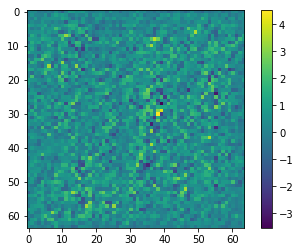

1 [D loss: 6.735252] [G loss: 0.538669]
2 [D loss: 5.079583] [G loss: 0.870249]
3 [D loss: 3.183220] [G loss: 1.314836]
4 [D loss: 1.283068] [G loss: 1.414626]
5 [D loss: 0.035119] [G loss: 1.295743]
6 [D loss: -0.448092] [G loss: 2.154395]
7 [D loss: -2.134793] [G loss: 2.338501]
8 [D loss: -2.484021] [G loss: 2.674245]
9 [D loss: -3.701087] [G loss: 2.980718]
10 [D loss: -4.068170] [G loss: 2.492127]
11 [D loss: -4.625762] [G loss: 3.297940]
12 [D loss: -5.046190] [G loss: 3.068738]
13 [D loss: -5.368962] [G loss: 3.353014]
14 [D loss: -5.758852] [G loss: 3.497862]
15 [D loss: -5.664162] [G loss: 3.335128]
16 [D loss: -5.663916] [G loss: 3.673705]
17 [D loss: -6.175732] [G loss: 3.435220]
18 [D loss: -6.421174] [G loss: 3.569619]
19 [D loss: -5.603585] [G loss: 3.630213]
20 [D loss: -6.378992] [G loss: 3.526336]
21 [D loss: -5.914242] [G loss: 3.308699]
22 [D loss: -6.563036] [G loss: 3.432454]
23 [D loss: -6.343063] [G loss: 3.942498]
24 [D loss: -6.468007] [G loss: 3.567617]
25 [D 

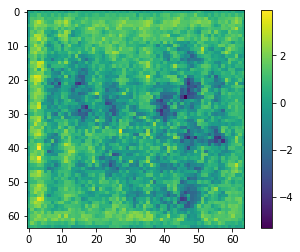

51 [D loss: -5.004571] [G loss: 2.333209]
52 [D loss: -5.117623] [G loss: 1.938228]
53 [D loss: -4.422725] [G loss: 2.321722]
54 [D loss: -4.757598] [G loss: 2.703779]
55 [D loss: -3.497068] [G loss: 1.038201]
56 [D loss: -3.818916] [G loss: 1.161283]
57 [D loss: -3.436306] [G loss: 0.923229]
58 [D loss: -2.488499] [G loss: 0.550789]
59 [D loss: -3.107398] [G loss: 0.831395]
60 [D loss: -2.980239] [G loss: 0.965259]
61 [D loss: -2.957301] [G loss: 0.094793]
62 [D loss: -2.877565] [G loss: 0.131277]
63 [D loss: -3.184633] [G loss: -0.334564]
64 [D loss: -2.983051] [G loss: 0.463030]
65 [D loss: -3.455132] [G loss: 1.309242]
66 [D loss: -3.551761] [G loss: 1.346297]
67 [D loss: -3.793565] [G loss: 1.113141]
68 [D loss: -3.759953] [G loss: 2.217676]
69 [D loss: -4.557020] [G loss: 3.227937]
70 [D loss: -4.773944] [G loss: 2.060126]
71 [D loss: -5.102736] [G loss: 3.338455]
72 [D loss: -4.429742] [G loss: 2.439075]
73 [D loss: -5.057807] [G loss: 3.580144]
74 [D loss: -5.049972] [G loss: 3

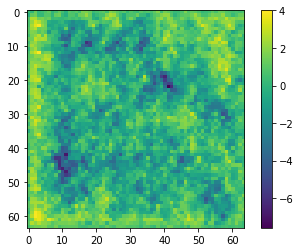

101 [D loss: -2.752904] [G loss: 1.692071]
102 [D loss: -2.622008] [G loss: 2.057080]
103 [D loss: -3.098847] [G loss: -0.606227]
104 [D loss: -2.513945] [G loss: 1.410077]
105 [D loss: -2.697470] [G loss: 1.751950]
106 [D loss: -2.962208] [G loss: 0.695808]
107 [D loss: -2.594522] [G loss: -0.921731]
108 [D loss: -1.766109] [G loss: -0.251766]
109 [D loss: -2.131516] [G loss: 1.205964]
110 [D loss: -1.597943] [G loss: 0.428561]
111 [D loss: -1.655554] [G loss: -0.124871]
112 [D loss: -1.299443] [G loss: -0.370093]
113 [D loss: -1.484891] [G loss: 2.023393]
114 [D loss: -1.827950] [G loss: 1.699057]
115 [D loss: -1.700838] [G loss: 1.452592]
116 [D loss: -0.972574] [G loss: 1.534768]
117 [D loss: -1.730886] [G loss: 1.333584]
118 [D loss: -1.476648] [G loss: 1.044537]
119 [D loss: -1.185128] [G loss: 0.430242]
120 [D loss: -1.384178] [G loss: -0.190659]
121 [D loss: -1.826020] [G loss: 0.720587]
122 [D loss: -2.276381] [G loss: 1.267535]
123 [D loss: -1.495846] [G loss: -0.779768]
124 

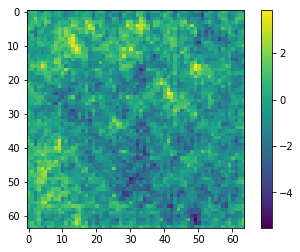

151 [D loss: -0.091396] [G loss: 1.534597]
152 [D loss: -1.199354] [G loss: 1.210379]
153 [D loss: -0.973261] [G loss: -2.005642]
154 [D loss: -1.412637] [G loss: -0.818473]
155 [D loss: -1.827892] [G loss: 0.192489]
156 [D loss: -0.963976] [G loss: -0.776168]
157 [D loss: -1.030017] [G loss: 1.302562]
158 [D loss: -0.658081] [G loss: -0.575728]
159 [D loss: -0.505204] [G loss: 0.193987]
160 [D loss: -0.100635] [G loss: -1.747705]
161 [D loss: -0.392472] [G loss: -0.257791]
162 [D loss: -0.798024] [G loss: 0.039457]
163 [D loss: -0.434279] [G loss: 2.386788]
164 [D loss: -0.853291] [G loss: -0.854587]
165 [D loss: -1.225829] [G loss: -0.219091]
166 [D loss: -1.087568] [G loss: -1.205551]
167 [D loss: -1.017851] [G loss: 0.470969]
168 [D loss: -0.660680] [G loss: -0.492598]
169 [D loss: -0.192944] [G loss: -2.481212]
170 [D loss: -0.584010] [G loss: -0.221056]
171 [D loss: -0.095096] [G loss: -2.359818]
172 [D loss: 0.239257] [G loss: -2.736614]
173 [D loss: 0.236731] [G loss: -3.380501

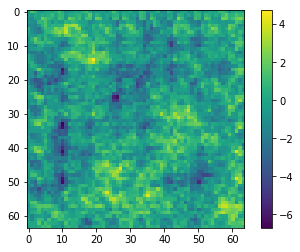

201 [D loss: 1.243795] [G loss: -1.171184]
202 [D loss: 0.871629] [G loss: -2.748656]
203 [D loss: 0.511124] [G loss: 1.257500]
204 [D loss: 0.322978] [G loss: 1.473308]
205 [D loss: 0.692917] [G loss: 3.129768]
206 [D loss: 0.567464] [G loss: 3.287117]
207 [D loss: 1.575969] [G loss: 3.263317]
208 [D loss: 1.577328] [G loss: 1.845514]
209 [D loss: 1.193651] [G loss: 4.389747]
210 [D loss: 1.739277] [G loss: 2.235183]
211 [D loss: 1.618255] [G loss: 2.133435]
212 [D loss: 1.634186] [G loss: 2.507854]
213 [D loss: 1.795029] [G loss: 2.778723]
214 [D loss: 1.723694] [G loss: 2.214190]
215 [D loss: 1.227083] [G loss: 1.950098]
216 [D loss: 0.820693] [G loss: -0.604124]
217 [D loss: 1.232806] [G loss: 0.656255]
218 [D loss: 1.436526] [G loss: 1.310838]
219 [D loss: 1.413305] [G loss: 0.918689]
220 [D loss: 2.190632] [G loss: -0.600882]
221 [D loss: 2.008474] [G loss: 0.913196]
222 [D loss: 2.077434] [G loss: -0.270099]
223 [D loss: 1.264909] [G loss: 1.004194]
224 [D loss: 0.637440] [G los

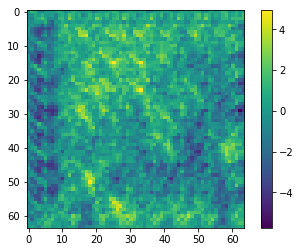

251 [D loss: -0.644901] [G loss: 1.940178]
252 [D loss: 0.024107] [G loss: 1.555582]
253 [D loss: -0.486824] [G loss: 1.313652]
254 [D loss: 0.358572] [G loss: -0.626446]
255 [D loss: 0.014209] [G loss: -0.115398]
256 [D loss: -0.362229] [G loss: 2.247216]
257 [D loss: 0.415851] [G loss: 2.172008]
258 [D loss: 1.134453] [G loss: -2.203972]
259 [D loss: 1.104174] [G loss: 1.896696]
260 [D loss: 1.521177] [G loss: 1.062724]
261 [D loss: 1.614649] [G loss: 1.258757]
262 [D loss: 0.997049] [G loss: 2.000244]
263 [D loss: -0.364851] [G loss: 0.058509]
264 [D loss: -1.254210] [G loss: -1.133397]
265 [D loss: -1.616616] [G loss: -1.121670]
266 [D loss: -1.060128] [G loss: -1.206192]
267 [D loss: -0.463123] [G loss: -0.906839]
268 [D loss: 0.650740] [G loss: -0.491613]
269 [D loss: 0.684743] [G loss: 0.216656]
270 [D loss: 0.651130] [G loss: 2.589407]
271 [D loss: 1.078899] [G loss: 1.959795]
272 [D loss: 1.453255] [G loss: -0.302636]
273 [D loss: 1.328885] [G loss: 1.150994]
274 [D loss: -0.2

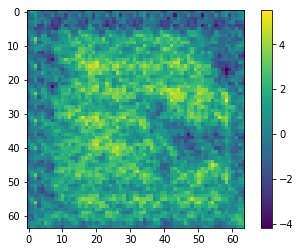

301 [D loss: -0.687113] [G loss: -2.158433]
302 [D loss: 0.339372] [G loss: -2.014857]
303 [D loss: 0.016717] [G loss: -1.311919]
304 [D loss: -0.214206] [G loss: -0.733891]
305 [D loss: -0.412513] [G loss: -0.913080]
306 [D loss: -0.909868] [G loss: -2.107146]
307 [D loss: -0.064125] [G loss: -0.639008]
308 [D loss: -0.083273] [G loss: -1.876003]
309 [D loss: 0.600127] [G loss: -1.876626]
310 [D loss: 0.949027] [G loss: -2.083490]
311 [D loss: 0.856955] [G loss: -2.709255]
312 [D loss: 0.292936] [G loss: -3.059900]
313 [D loss: 0.028022] [G loss: 1.017153]
314 [D loss: -0.215798] [G loss: 1.301262]
315 [D loss: 0.083807] [G loss: 1.290950]
316 [D loss: -0.524827] [G loss: 1.288778]
317 [D loss: -0.002255] [G loss: 0.640879]
318 [D loss: -0.986914] [G loss: -0.716937]
319 [D loss: -0.964628] [G loss: 0.590041]
320 [D loss: -1.070604] [G loss: 1.451003]
321 [D loss: -0.908734] [G loss: 1.006298]
322 [D loss: -0.418627] [G loss: 1.362694]
323 [D loss: -0.092361] [G loss: 3.012491]
324 [D

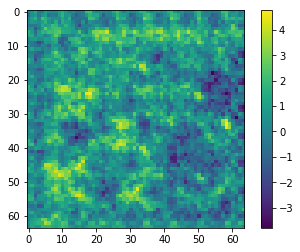

351 [D loss: -2.092291] [G loss: 0.479250]
352 [D loss: -1.877318] [G loss: 0.612579]
353 [D loss: -2.035121] [G loss: 0.296741]
354 [D loss: -1.470327] [G loss: -0.000248]
355 [D loss: -1.483613] [G loss: 2.485881]
356 [D loss: -2.176674] [G loss: 0.911582]
357 [D loss: -1.719534] [G loss: 1.272077]
358 [D loss: -0.968332] [G loss: -0.319864]
359 [D loss: -0.334044] [G loss: -0.374346]
360 [D loss: -0.079600] [G loss: -1.347620]
361 [D loss: -0.058013] [G loss: 0.437108]
362 [D loss: -0.801383] [G loss: -0.830655]
363 [D loss: -1.018908] [G loss: 0.099439]
364 [D loss: -1.399999] [G loss: -0.124790]
365 [D loss: -1.440451] [G loss: -0.295360]
366 [D loss: -0.523227] [G loss: 0.372892]
367 [D loss: 0.110315] [G loss: -0.574938]
368 [D loss: 0.369229] [G loss: -2.639061]
369 [D loss: 0.277914] [G loss: -1.483561]
370 [D loss: -0.887954] [G loss: -0.078464]
371 [D loss: -1.669621] [G loss: 0.583045]
372 [D loss: -2.068162] [G loss: -1.624380]
373 [D loss: -1.621761] [G loss: 0.933807]
37

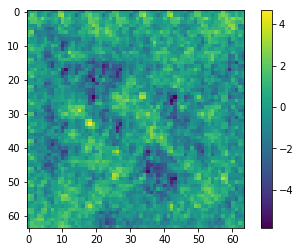

401 [D loss: -0.802637] [G loss: 0.589821]
402 [D loss: -0.763119] [G loss: 2.123802]
403 [D loss: -0.726815] [G loss: -0.676362]
404 [D loss: -0.978168] [G loss: 1.441504]
405 [D loss: -0.790046] [G loss: 1.316974]
406 [D loss: -1.391032] [G loss: -0.274207]
407 [D loss: -1.061433] [G loss: -0.300005]
408 [D loss: -1.413377] [G loss: -1.484752]
409 [D loss: -1.514815] [G loss: -0.513282]
410 [D loss: -1.251851] [G loss: -1.269191]
411 [D loss: -1.129141] [G loss: -1.943416]
412 [D loss: -0.636429] [G loss: 0.126726]
413 [D loss: -1.132292] [G loss: 1.602284]
414 [D loss: -2.343239] [G loss: 2.318172]
415 [D loss: -2.429036] [G loss: 1.263054]
416 [D loss: -1.463952] [G loss: 0.416973]
417 [D loss: -0.949779] [G loss: 0.347077]
418 [D loss: -0.281744] [G loss: 1.195174]
419 [D loss: 0.585034] [G loss: 2.566212]
420 [D loss: 0.752551] [G loss: 0.468914]
421 [D loss: -2.190418] [G loss: 0.145930]
422 [D loss: -2.486479] [G loss: 2.922010]
423 [D loss: -2.914048] [G loss: -0.334640]
424 [

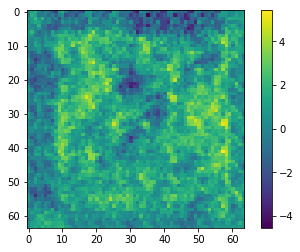

451 [D loss: -0.725571] [G loss: -1.580247]
452 [D loss: -0.941604] [G loss: -1.764220]
453 [D loss: 0.000969] [G loss: -2.016912]
454 [D loss: -0.035957] [G loss: -1.588739]
455 [D loss: -0.438854] [G loss: 0.265796]
456 [D loss: -1.334651] [G loss: -1.991633]
457 [D loss: -1.781034] [G loss: -1.898390]
458 [D loss: -1.643047] [G loss: -2.049680]
459 [D loss: -0.842475] [G loss: -2.249165]
460 [D loss: -0.153288] [G loss: -2.412839]
461 [D loss: 0.295012] [G loss: -2.104273]
462 [D loss: -0.144155] [G loss: 1.979238]
463 [D loss: -1.281327] [G loss: 1.099077]
464 [D loss: -1.409759] [G loss: 2.105088]
465 [D loss: -0.539665] [G loss: 1.733812]
466 [D loss: -0.152478] [G loss: 0.504509]
467 [D loss: 0.447807] [G loss: 1.672394]
468 [D loss: -1.387570] [G loss: -1.230175]
469 [D loss: -1.356550] [G loss: -0.822844]
470 [D loss: -1.279205] [G loss: -0.036449]
471 [D loss: -1.003001] [G loss: -1.026999]
472 [D loss: -0.410380] [G loss: -1.149958]
473 [D loss: 0.138222] [G loss: 0.714958]


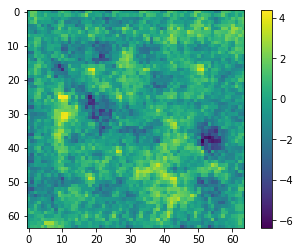

501 [D loss: -0.619013] [G loss: 2.090818]
502 [D loss: -0.695682] [G loss: -1.188869]
503 [D loss: -1.746515] [G loss: 0.568141]
504 [D loss: -0.533093] [G loss: -1.182868]
505 [D loss: -0.644134] [G loss: 0.356486]
506 [D loss: -0.317981] [G loss: 1.108979]
507 [D loss: 0.205051] [G loss: 1.352358]
508 [D loss: -0.706469] [G loss: 2.138430]
509 [D loss: -0.715066] [G loss: 0.976805]
510 [D loss: -0.876926] [G loss: -0.374015]
511 [D loss: -0.547323] [G loss: -1.943198]
512 [D loss: 0.797173] [G loss: -2.927526]
513 [D loss: 1.237540] [G loss: -1.339407]
514 [D loss: 0.765886] [G loss: -0.603945]
515 [D loss: -0.366736] [G loss: 3.949834]
516 [D loss: -0.226964] [G loss: -0.966043]
517 [D loss: -0.262164] [G loss: -1.484277]
518 [D loss: -0.610671] [G loss: -2.541037]
519 [D loss: 0.414820] [G loss: -3.213970]
520 [D loss: 0.473412] [G loss: -0.195753]
521 [D loss: 1.681607] [G loss: 1.821311]
522 [D loss: 1.339810] [G loss: 2.622229]
523 [D loss: 0.827183] [G loss: 2.530764]
524 [D l

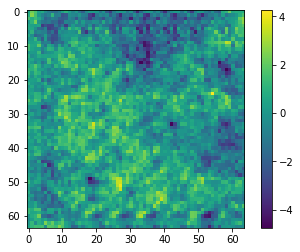

551 [D loss: 1.091281] [G loss: -3.857716]
552 [D loss: 1.201163] [G loss: 0.186849]
553 [D loss: -0.545702] [G loss: 0.828155]
554 [D loss: -1.954563] [G loss: 0.093586]
555 [D loss: -1.288063] [G loss: 0.417235]
556 [D loss: -0.699477] [G loss: 2.364827]
557 [D loss: -0.077477] [G loss: 0.493676]
558 [D loss: -0.754718] [G loss: -1.804090]
559 [D loss: -1.076891] [G loss: -1.771433]
560 [D loss: -1.605546] [G loss: 1.901453]
561 [D loss: -1.230024] [G loss: 0.712470]
562 [D loss: -0.647564] [G loss: 2.051236]
563 [D loss: -0.049119] [G loss: -0.704218]
564 [D loss: -0.420527] [G loss: 3.044902]
565 [D loss: -0.739721] [G loss: -0.029460]
566 [D loss: -1.454210] [G loss: -1.689737]
567 [D loss: -0.510613] [G loss: 0.003482]
568 [D loss: -0.053452] [G loss: -1.394151]
569 [D loss: 0.284634] [G loss: -2.373707]
570 [D loss: 0.700973] [G loss: -1.969622]
571 [D loss: -0.451333] [G loss: -0.086058]
572 [D loss: -1.485241] [G loss: -1.008766]
573 [D loss: -0.932238] [G loss: -2.647271]
574

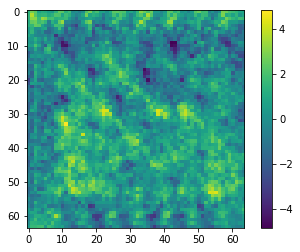

601 [D loss: -0.941243] [G loss: -1.225625]
602 [D loss: -0.921346] [G loss: 1.074000]
603 [D loss: -0.915293] [G loss: 2.000042]
604 [D loss: -0.326059] [G loss: 3.367249]
605 [D loss: 0.137660] [G loss: 1.976558]
606 [D loss: -0.262548] [G loss: 4.956694]
607 [D loss: -0.440315] [G loss: -0.646889]
608 [D loss: -0.995514] [G loss: -1.904471]
609 [D loss: -0.814551] [G loss: -1.856485]
610 [D loss: -0.071683] [G loss: -3.323002]
611 [D loss: 0.701330] [G loss: -2.952513]
612 [D loss: 0.459935] [G loss: -3.097009]
613 [D loss: 0.309598] [G loss: -0.922363]
614 [D loss: -0.847689] [G loss: 1.309740]
615 [D loss: -1.138356] [G loss: 0.254883]
616 [D loss: -0.670174] [G loss: -1.811445]
617 [D loss: -0.288776] [G loss: -2.105109]
618 [D loss: 0.496540] [G loss: -3.190209]
619 [D loss: 0.515741] [G loss: -1.985978]
620 [D loss: 1.088419] [G loss: -1.912130]
621 [D loss: 1.781096] [G loss: -1.956426]
622 [D loss: 1.912465] [G loss: 2.915886]
623 [D loss: 2.688202] [G loss: 3.920329]
624 [D 

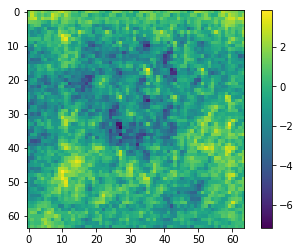

651 [D loss: 0.087605] [G loss: 4.338081]
652 [D loss: 0.362195] [G loss: 4.639874]
653 [D loss: 0.813034] [G loss: 3.914342]
654 [D loss: 0.659219] [G loss: 3.195461]
655 [D loss: 0.065687] [G loss: 4.832574]
656 [D loss: -0.221358] [G loss: 3.272635]
657 [D loss: -0.204080] [G loss: 3.341578]
658 [D loss: -0.185391] [G loss: 3.091437]
659 [D loss: -0.059043] [G loss: -0.550345]
660 [D loss: 0.345124] [G loss: 0.279644]
661 [D loss: 0.209818] [G loss: 0.879418]
662 [D loss: 0.244406] [G loss: -1.374787]
663 [D loss: 0.656415] [G loss: -1.209131]
664 [D loss: -0.013835] [G loss: -1.488061]
665 [D loss: -0.146908] [G loss: 1.578572]
666 [D loss: -0.407794] [G loss: 2.699605]
667 [D loss: -0.110289] [G loss: 4.153817]
668 [D loss: -0.360477] [G loss: 3.682528]
669 [D loss: -0.541574] [G loss: 3.560342]
670 [D loss: -1.164670] [G loss: 3.460276]
671 [D loss: -1.092168] [G loss: 2.742549]
672 [D loss: -0.492406] [G loss: 2.970756]
673 [D loss: -0.188718] [G loss: 3.128941]
674 [D loss: 0.4

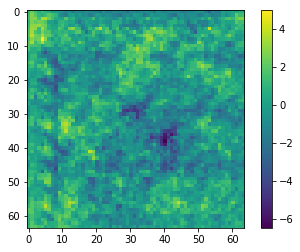

701 [D loss: -0.312879] [G loss: -1.263417]
702 [D loss: -0.491204] [G loss: 0.068511]
703 [D loss: 0.066805] [G loss: -1.757554]
704 [D loss: 0.386724] [G loss: -3.626634]
705 [D loss: -0.437089] [G loss: -3.910837]
706 [D loss: -0.391464] [G loss: -3.378114]
707 [D loss: -0.448833] [G loss: -2.824454]
708 [D loss: -0.980383] [G loss: -1.423303]
709 [D loss: -1.585570] [G loss: -1.483212]
710 [D loss: -0.852592] [G loss: -2.565747]
711 [D loss: -0.503114] [G loss: -4.593125]
712 [D loss: 0.626265] [G loss: -4.957493]
713 [D loss: 0.878793] [G loss: -5.148854]
714 [D loss: 1.383140] [G loss: -4.257970]
715 [D loss: 0.681048] [G loss: -0.757487]
716 [D loss: 1.220613] [G loss: 1.799088]
717 [D loss: 0.085473] [G loss: 0.248342]
718 [D loss: -1.156060] [G loss: 2.279143]
719 [D loss: -1.326627] [G loss: 1.719831]
720 [D loss: -1.962919] [G loss: 3.912591]
721 [D loss: -2.433343] [G loss: 5.054084]
722 [D loss: -1.434103] [G loss: 4.814328]
723 [D loss: -1.080870] [G loss: 3.474799]
724 [

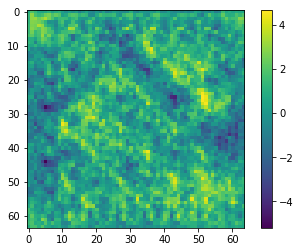

751 [D loss: 0.024446] [G loss: -2.268847]
752 [D loss: 0.607348] [G loss: -3.476377]
753 [D loss: 0.757955] [G loss: -5.144483]
754 [D loss: 1.529023] [G loss: -2.264670]
755 [D loss: 0.471647] [G loss: -0.921729]
756 [D loss: -0.946058] [G loss: 1.114871]
757 [D loss: -1.835890] [G loss: 1.730509]
758 [D loss: -1.200470] [G loss: 0.618233]
759 [D loss: -0.778863] [G loss: 0.776827]
760 [D loss: -0.451632] [G loss: 2.625420]
761 [D loss: -0.204678] [G loss: 0.630144]
762 [D loss: 0.009970] [G loss: 0.959530]
763 [D loss: 0.402536] [G loss: 0.200806]
764 [D loss: -0.778164] [G loss: 3.315683]
765 [D loss: -1.032642] [G loss: 1.884131]
766 [D loss: -0.875125] [G loss: -0.536040]
767 [D loss: -1.062068] [G loss: 0.675169]
768 [D loss: -0.828733] [G loss: 1.629643]
769 [D loss: 0.346694] [G loss: 1.632805]
770 [D loss: -0.270118] [G loss: 1.578908]
771 [D loss: 0.042709] [G loss: 2.053198]
772 [D loss: -1.589206] [G loss: -0.688880]
773 [D loss: -2.112821] [G loss: 2.141641]
774 [D loss: 

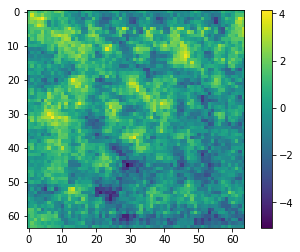

801 [D loss: -1.062537] [G loss: -5.131711]
802 [D loss: -0.254184] [G loss: -2.515268]
803 [D loss: -0.704152] [G loss: -2.020347]
804 [D loss: -0.462487] [G loss: -2.476944]
805 [D loss: 0.038156] [G loss: -1.903911]
806 [D loss: -0.263148] [G loss: -1.596459]
807 [D loss: 0.116226] [G loss: -3.460483]
808 [D loss: 0.684766] [G loss: -3.686529]
809 [D loss: 0.087803] [G loss: -4.089142]
810 [D loss: -0.019773] [G loss: -3.141160]
811 [D loss: -0.250409] [G loss: -1.366530]
812 [D loss: -0.741086] [G loss: 0.089334]
813 [D loss: -0.895499] [G loss: -0.663108]
814 [D loss: -1.350904] [G loss: -0.626503]
815 [D loss: -0.991636] [G loss: 1.322553]
816 [D loss: -0.176080] [G loss: -1.255616]
817 [D loss: -0.085899] [G loss: -2.318447]
818 [D loss: -0.194120] [G loss: -2.806618]
819 [D loss: -0.382905] [G loss: -3.506022]
820 [D loss: -0.805586] [G loss: -0.504745]
821 [D loss: -0.881079] [G loss: -1.011148]
822 [D loss: -0.616030] [G loss: -1.945358]
823 [D loss: -0.426892] [G loss: -0.71

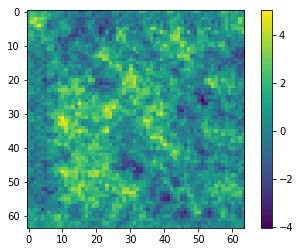

851 [D loss: -0.248813] [G loss: 2.955767]
852 [D loss: -0.316423] [G loss: 0.569980]
853 [D loss: -1.038779] [G loss: 2.215007]
854 [D loss: -0.893089] [G loss: -1.091023]
855 [D loss: -0.507276] [G loss: 0.151796]
856 [D loss: 0.149650] [G loss: 2.066843]
857 [D loss: 0.275706] [G loss: 5.196606]
858 [D loss: -0.304350] [G loss: 0.573894]
859 [D loss: -0.539699] [G loss: 1.411683]
860 [D loss: 0.220327] [G loss: -3.063223]
861 [D loss: -0.174845] [G loss: 1.729159]
862 [D loss: -0.345054] [G loss: 3.594584]
863 [D loss: -0.618247] [G loss: -2.090211]
864 [D loss: -0.978927] [G loss: 2.326925]
865 [D loss: -1.356038] [G loss: 2.731123]
866 [D loss: -0.257128] [G loss: 2.487999]
867 [D loss: -0.569955] [G loss: 3.073926]
868 [D loss: 0.140821] [G loss: 0.319463]
869 [D loss: 0.957298] [G loss: -1.278835]
870 [D loss: 0.706494] [G loss: 1.986803]
871 [D loss: -0.467713] [G loss: 0.424365]
872 [D loss: -0.272318] [G loss: 0.686793]
873 [D loss: -0.535148] [G loss: 3.833517]
874 [D loss: 

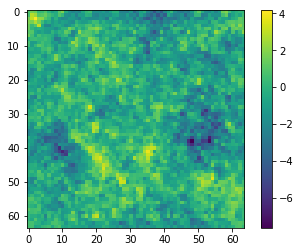

901 [D loss: -0.093437] [G loss: 0.616087]
902 [D loss: -0.233860] [G loss: 0.822862]
903 [D loss: -0.379961] [G loss: 0.269865]
904 [D loss: -0.777923] [G loss: 2.016700]
905 [D loss: -2.211326] [G loss: 1.645702]
906 [D loss: -2.660240] [G loss: 3.444134]
907 [D loss: -1.890815] [G loss: 3.491789]
908 [D loss: -0.676870] [G loss: 3.330625]
909 [D loss: -1.324798] [G loss: 1.553026]
910 [D loss: 0.291131] [G loss: 1.985161]
911 [D loss: 0.579882] [G loss: 0.280394]
912 [D loss: 0.702808] [G loss: 3.563972]
913 [D loss: 0.366212] [G loss: 3.940715]
914 [D loss: -0.114323] [G loss: 3.843981]
915 [D loss: -0.900524] [G loss: 3.155298]
916 [D loss: -0.398481] [G loss: 4.021565]
917 [D loss: -0.154547] [G loss: 2.422888]
918 [D loss: -0.623646] [G loss: 2.855634]
919 [D loss: 0.678271] [G loss: 0.397366]
920 [D loss: 0.117515] [G loss: 2.888572]
921 [D loss: 0.730425] [G loss: 1.639791]
922 [D loss: 0.117182] [G loss: 4.267338]
923 [D loss: -0.740355] [G loss: 4.945050]
924 [D loss: 0.6274

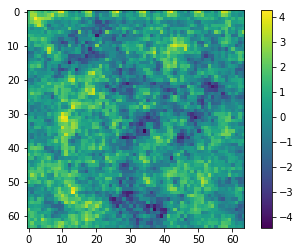

951 [D loss: 1.578562] [G loss: 1.296970]
952 [D loss: 1.790451] [G loss: 1.065522]
953 [D loss: 2.273373] [G loss: -0.875280]
954 [D loss: 1.570815] [G loss: 2.415408]
955 [D loss: 0.202528] [G loss: 2.210255]
956 [D loss: -2.545503] [G loss: 1.613765]
957 [D loss: -2.015557] [G loss: -2.682063]
958 [D loss: -2.936589] [G loss: -1.596746]
959 [D loss: -1.637909] [G loss: -0.566980]
960 [D loss: -0.940928] [G loss: -1.362721]
961 [D loss: -0.062886] [G loss: -1.973829]
962 [D loss: -0.530315] [G loss: 2.889417]
963 [D loss: -0.505373] [G loss: 1.168217]
964 [D loss: -0.219390] [G loss: -0.051606]
965 [D loss: 0.294189] [G loss: 3.440232]
966 [D loss: 0.065553] [G loss: 0.653364]
967 [D loss: 0.539549] [G loss: 0.872123]
968 [D loss: 0.710739] [G loss: -3.531114]
969 [D loss: -0.019418] [G loss: 0.504016]
970 [D loss: -0.589732] [G loss: -0.044054]
971 [D loss: -1.227870] [G loss: -1.130924]
972 [D loss: -1.884696] [G loss: -0.753679]
973 [D loss: -2.537636] [G loss: -0.753416]
974 [D l

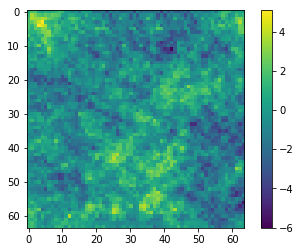

1001 [D loss: -0.517634] [G loss: -4.136124]
1002 [D loss: 0.508364] [G loss: 0.263033]
1003 [D loss: 0.128537] [G loss: 6.023588]
1004 [D loss: 0.658276] [G loss: 3.491167]
1005 [D loss: 0.705289] [G loss: 6.427858]
1006 [D loss: 1.416761] [G loss: 6.523657]
1007 [D loss: 1.405239] [G loss: 6.134902]
1008 [D loss: 0.996961] [G loss: 3.210265]
1009 [D loss: 1.499896] [G loss: 1.952557]
1010 [D loss: 0.854727] [G loss: -1.281696]
1011 [D loss: -0.671534] [G loss: -4.047065]
1012 [D loss: -0.640467] [G loss: -2.500718]
1013 [D loss: 0.075320] [G loss: -3.982027]
1014 [D loss: -0.149531] [G loss: -3.000002]
1015 [D loss: 1.538597] [G loss: -4.074115]
1016 [D loss: 1.746314] [G loss: -4.316156]
1017 [D loss: 1.946846] [G loss: -5.785740]
1018 [D loss: 2.313932] [G loss: -5.352738]
1019 [D loss: 2.288159] [G loss: -4.145457]
1020 [D loss: 1.787106] [G loss: -3.495138]
1021 [D loss: 2.417709] [G loss: -2.359145]
1022 [D loss: 0.691793] [G loss: -0.428405]
1023 [D loss: -0.932632] [G loss: -0

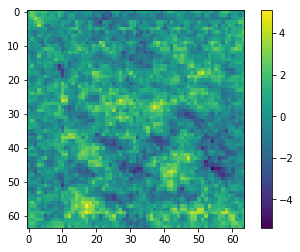

1051 [D loss: 0.579235] [G loss: 6.726956]
1052 [D loss: 1.871783] [G loss: 5.554738]
1053 [D loss: 0.556727] [G loss: 6.179061]
1054 [D loss: 0.613830] [G loss: 6.212752]
1055 [D loss: -1.209892] [G loss: 2.992344]
1056 [D loss: -1.829917] [G loss: 2.339043]
1057 [D loss: -2.122297] [G loss: 0.682316]
1058 [D loss: -1.996817] [G loss: 2.489190]
1059 [D loss: -2.109618] [G loss: 1.024841]
1060 [D loss: -1.212522] [G loss: 0.208443]
1061 [D loss: -1.564008] [G loss: 0.299045]
1062 [D loss: -0.607635] [G loss: 1.387877]
1063 [D loss: -1.367391] [G loss: -2.554369]
1064 [D loss: -0.684111] [G loss: -1.555268]
1065 [D loss: 0.881099] [G loss: 0.385330]
1066 [D loss: 1.177114] [G loss: 4.565239]
1067 [D loss: 1.097618] [G loss: 3.487748]
1068 [D loss: 0.562004] [G loss: 5.646004]
1069 [D loss: 0.444868] [G loss: 5.113913]
1070 [D loss: -0.909710] [G loss: -3.523389]
1071 [D loss: -1.838526] [G loss: -1.732314]
1072 [D loss: -1.838172] [G loss: -1.424360]
1073 [D loss: -1.928739] [G loss: -0

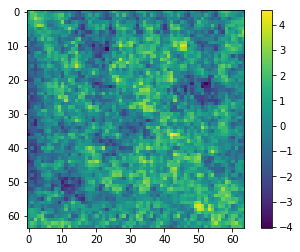

1101 [D loss: -0.348697] [G loss: -0.497764]
1102 [D loss: 0.204706] [G loss: 2.259163]
1103 [D loss: -0.253958] [G loss: 2.753712]
1104 [D loss: 0.103002] [G loss: 1.811170]
1105 [D loss: -0.245858] [G loss: 3.739156]
1106 [D loss: 0.125958] [G loss: 3.059617]
1107 [D loss: -0.119458] [G loss: 5.100088]
1108 [D loss: 0.710948] [G loss: 4.259600]
1109 [D loss: 0.631586] [G loss: 4.804236]
1110 [D loss: -0.727649] [G loss: -0.260802]
1111 [D loss: -1.468041] [G loss: -3.471601]
1112 [D loss: -1.149060] [G loss: -3.754014]
1113 [D loss: -0.775093] [G loss: -2.163787]
1114 [D loss: -1.778768] [G loss: -3.261557]
1115 [D loss: -1.114801] [G loss: 0.581011]
1116 [D loss: -1.382242] [G loss: -1.830797]
1117 [D loss: -0.414254] [G loss: -1.902737]
1118 [D loss: -0.655402] [G loss: -1.318251]
1119 [D loss: -0.459687] [G loss: -0.323991]
1120 [D loss: -0.072765] [G loss: -1.844703]
1121 [D loss: 0.069811] [G loss: 1.333826]
1122 [D loss: -0.820973] [G loss: 2.212323]
1123 [D loss: -0.739816] [G

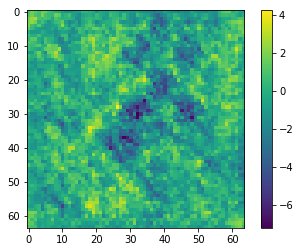

1151 [D loss: 0.342278] [G loss: 5.219995]
1152 [D loss: -0.079071] [G loss: 5.933569]
1153 [D loss: 0.743710] [G loss: 5.784857]
1154 [D loss: 2.239292] [G loss: 3.538521]
1155 [D loss: 1.476176] [G loss: 5.527501]
1156 [D loss: 2.648420] [G loss: 5.838729]
1157 [D loss: 2.662705] [G loss: 3.602240]
1158 [D loss: 2.308669] [G loss: 2.398275]
1159 [D loss: 1.335123] [G loss: 3.401359]
1160 [D loss: 0.283018] [G loss: -0.860152]
1161 [D loss: -0.483734] [G loss: 0.779217]
1162 [D loss: -1.691519] [G loss: -1.593314]
1163 [D loss: -1.350478] [G loss: -3.232822]
1164 [D loss: -1.377171] [G loss: -4.078232]
1165 [D loss: -0.646013] [G loss: -5.946168]
1166 [D loss: -0.017383] [G loss: -5.657689]
1167 [D loss: 0.533960] [G loss: -6.544256]
1168 [D loss: 0.451772] [G loss: -7.655129]
1169 [D loss: 2.033487] [G loss: -8.652945]
1170 [D loss: 0.580595] [G loss: -7.346114]
1171 [D loss: -0.095653] [G loss: -6.520168]
1172 [D loss: 0.185456] [G loss: -6.517018]
1173 [D loss: -0.713796] [G loss: 

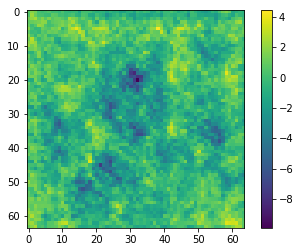

1201 [D loss: 0.089100] [G loss: -3.597312]
1202 [D loss: 0.437513] [G loss: -5.151797]
1203 [D loss: -0.067778] [G loss: -3.185132]
1204 [D loss: -0.439679] [G loss: -1.670940]
1205 [D loss: -0.068788] [G loss: -1.489818]
1206 [D loss: -1.000452] [G loss: 0.805575]
1207 [D loss: -0.104871] [G loss: 0.952119]
1208 [D loss: -0.656939] [G loss: 2.378791]
1209 [D loss: -0.196485] [G loss: 2.829226]
1210 [D loss: 0.171255] [G loss: 2.144445]
1211 [D loss: -0.458465] [G loss: 3.306023]
1212 [D loss: -0.179574] [G loss: 1.799136]
1213 [D loss: -0.103415] [G loss: 4.818956]
1214 [D loss: 0.206268] [G loss: 0.520436]
1215 [D loss: 0.381379] [G loss: -0.770237]
1216 [D loss: -0.463417] [G loss: 0.084426]
1217 [D loss: -0.554082] [G loss: 2.790709]
1218 [D loss: -0.023385] [G loss: 4.336067]
1219 [D loss: -0.293100] [G loss: 2.268517]
1220 [D loss: 0.037752] [G loss: 5.642748]
1221 [D loss: 0.359226] [G loss: 6.134299]
1222 [D loss: 0.850663] [G loss: 7.078094]
1223 [D loss: 0.660672] [G loss: 2

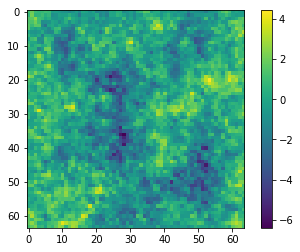

1251 [D loss: 0.910155] [G loss: -5.138919]
1252 [D loss: 1.628685] [G loss: -1.469584]
1253 [D loss: 2.030382] [G loss: -0.987290]
1254 [D loss: 0.894931] [G loss: 5.012524]
1255 [D loss: 0.528913] [G loss: 3.486959]
1256 [D loss: 0.303272] [G loss: 2.049033]
1257 [D loss: -0.653121] [G loss: 1.762893]
1258 [D loss: -0.648816] [G loss: -0.965274]
1259 [D loss: -0.980588] [G loss: -2.427904]
1260 [D loss: -0.938140] [G loss: -1.870249]
1261 [D loss: -0.126127] [G loss: -2.555809]
1262 [D loss: 0.038293] [G loss: -2.738175]
1263 [D loss: -0.185506] [G loss: -4.836158]
1264 [D loss: -0.826403] [G loss: -2.849249]
1265 [D loss: -1.626865] [G loss: -3.539788]
1266 [D loss: -1.041721] [G loss: -4.647570]
1267 [D loss: -1.697603] [G loss: -3.225519]
1268 [D loss: -1.080245] [G loss: -3.233845]
1269 [D loss: -1.033162] [G loss: -1.769949]
1270 [D loss: -0.874132] [G loss: -2.406624]
1271 [D loss: 0.843793] [G loss: 0.424478]
1272 [D loss: -0.086103] [G loss: -2.093342]
1273 [D loss: 0.898259]

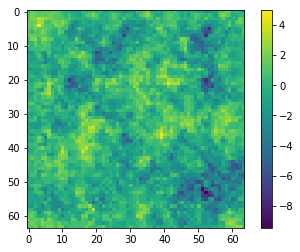

1301 [D loss: -0.942516] [G loss: -4.554648]
1302 [D loss: -1.763543] [G loss: -0.737269]
1303 [D loss: -1.267743] [G loss: -1.469523]
1304 [D loss: -1.868466] [G loss: -0.433094]
1305 [D loss: -0.840542] [G loss: -1.526191]
1306 [D loss: -0.225297] [G loss: -2.925845]
1307 [D loss: 0.609057] [G loss: -3.945526]
1308 [D loss: 0.679897] [G loss: -4.782570]
1309 [D loss: 1.125718] [G loss: -5.850506]
1310 [D loss: 1.033040] [G loss: -7.439155]
1311 [D loss: 0.480197] [G loss: -4.716279]
1312 [D loss: -0.675564] [G loss: -0.395507]
1313 [D loss: -0.339770] [G loss: -2.612271]
1314 [D loss: -0.238906] [G loss: 0.437213]
1315 [D loss: -0.200729] [G loss: 2.208258]
1316 [D loss: 0.407427] [G loss: 1.098079]
1317 [D loss: 0.587029] [G loss: 2.619628]
1318 [D loss: 0.816708] [G loss: 2.743048]
1319 [D loss: 1.367061] [G loss: 3.830870]
1320 [D loss: 2.634446] [G loss: 5.344888]
1321 [D loss: 1.566447] [G loss: 6.284360]
1322 [D loss: 2.183056] [G loss: 6.705782]
1323 [D loss: 2.149019] [G loss

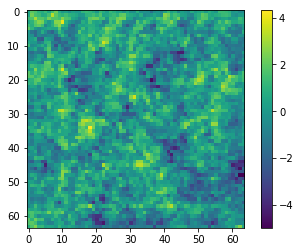

1351 [D loss: 3.008950] [G loss: 4.040453]
1352 [D loss: 2.672892] [G loss: 4.536802]
1353 [D loss: 1.121275] [G loss: 4.598394]
1354 [D loss: -1.729300] [G loss: 5.389647]
1355 [D loss: -2.044793] [G loss: 5.695325]
1356 [D loss: -3.379722] [G loss: 1.645717]
1357 [D loss: -2.936023] [G loss: 2.032275]
1358 [D loss: -2.057260] [G loss: -1.382429]
1359 [D loss: -0.827179] [G loss: -1.956712]
1360 [D loss: -1.149332] [G loss: -3.568138]
1361 [D loss: -0.875361] [G loss: -3.529490]
1362 [D loss: 0.111274] [G loss: -4.622009]
1363 [D loss: 0.444204] [G loss: -5.966539]
1364 [D loss: 0.423162] [G loss: -4.974360]
1365 [D loss: -0.844520] [G loss: 0.904274]
1366 [D loss: -2.843186] [G loss: 1.349151]
1367 [D loss: -2.692250] [G loss: 1.544810]
1368 [D loss: -2.927254] [G loss: 1.471798]
1369 [D loss: -1.818962] [G loss: 3.392313]
1370 [D loss: -0.912794] [G loss: 1.423172]
1371 [D loss: -0.046016] [G loss: 0.470255]
1372 [D loss: 0.829118] [G loss: 0.439802]
1373 [D loss: 1.056607] [G loss:

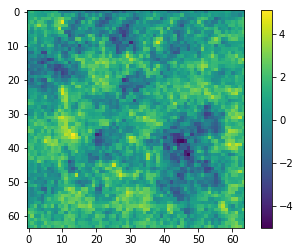

1401 [D loss: -1.903184] [G loss: -3.080720]
1402 [D loss: -1.505532] [G loss: -1.985404]
1403 [D loss: -0.729453] [G loss: -2.055841]
1404 [D loss: -1.130427] [G loss: -0.671900]
1405 [D loss: -0.435713] [G loss: -2.115030]
1406 [D loss: -0.013752] [G loss: -3.410470]
1407 [D loss: 0.766013] [G loss: -0.731637]
1408 [D loss: 1.258799] [G loss: 1.644760]
1409 [D loss: 1.927363] [G loss: 3.167948]
1410 [D loss: 1.451730] [G loss: 3.342565]
1411 [D loss: 1.785272] [G loss: 4.136217]
1412 [D loss: 1.457803] [G loss: 5.361345]
1413 [D loss: 0.295276] [G loss: 5.521835]
1414 [D loss: -1.514846] [G loss: 8.281417]
1415 [D loss: -1.075639] [G loss: 7.968766]
1416 [D loss: 0.850138] [G loss: 7.706371]
1417 [D loss: -0.725500] [G loss: 6.968609]
1418 [D loss: -0.998159] [G loss: 5.468705]
1419 [D loss: -0.993306] [G loss: 5.216705]
1420 [D loss: -0.377403] [G loss: 4.032314]
1421 [D loss: -0.425080] [G loss: 3.975043]
1422 [D loss: 0.493913] [G loss: 4.203942]
1423 [D loss: 0.581663] [G loss: 2

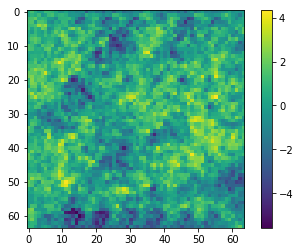

1451 [D loss: 0.590061] [G loss: -7.976153]
1452 [D loss: 2.934240] [G loss: -7.972893]
1453 [D loss: 1.799317] [G loss: -7.670462]
1454 [D loss: 1.472630] [G loss: -5.356681]
1455 [D loss: 0.625277] [G loss: -4.508367]
1456 [D loss: 0.755553] [G loss: -0.500252]
1457 [D loss: 0.793016] [G loss: 2.432056]
1458 [D loss: 1.731109] [G loss: 2.535665]
1459 [D loss: -0.408355] [G loss: -0.700558]
1460 [D loss: -0.982367] [G loss: -1.122140]
1461 [D loss: -1.449312] [G loss: -2.620914]
1462 [D loss: -0.555189] [G loss: -4.035499]
1463 [D loss: -0.084011] [G loss: -5.565210]
1464 [D loss: 0.344581] [G loss: -7.539675]
1465 [D loss: 0.801892] [G loss: -7.614434]
1466 [D loss: 0.371121] [G loss: -8.180607]
1467 [D loss: 0.695603] [G loss: -7.469623]
1468 [D loss: 1.178458] [G loss: -8.668346]
1469 [D loss: 1.573932] [G loss: -8.592055]
1470 [D loss: 0.700638] [G loss: -7.300057]
1471 [D loss: 1.658076] [G loss: -5.804272]
1472 [D loss: 0.261338] [G loss: 0.750755]
1473 [D loss: -0.823230] [G lo

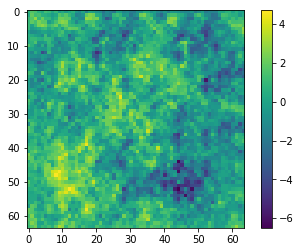

1501 [D loss: -2.109200] [G loss: 1.557648]
1502 [D loss: -2.317628] [G loss: 1.837123]
1503 [D loss: -2.096322] [G loss: 0.639048]
1504 [D loss: -1.555302] [G loss: 2.499406]
1505 [D loss: -1.086584] [G loss: 0.233040]
1506 [D loss: -1.361724] [G loss: -3.839799]
1507 [D loss: -0.641277] [G loss: -1.823228]
1508 [D loss: -0.671985] [G loss: -0.676171]
1509 [D loss: -0.432566] [G loss: -1.779548]
1510 [D loss: -0.724082] [G loss: -1.095008]
1511 [D loss: -0.435015] [G loss: 2.524365]
1512 [D loss: -0.540918] [G loss: 3.166990]
1513 [D loss: -0.524173] [G loss: 3.120766]
1514 [D loss: -1.345243] [G loss: -1.646918]
1515 [D loss: -1.313832] [G loss: -2.359120]
1516 [D loss: -1.738768] [G loss: -1.302386]
1517 [D loss: -0.647426] [G loss: 2.766533]
1518 [D loss: -0.913520] [G loss: 1.116201]
1519 [D loss: -0.856901] [G loss: 0.330287]
1520 [D loss: -0.762722] [G loss: 4.437860]
1521 [D loss: -0.815951] [G loss: -2.551788]
1522 [D loss: -0.652194] [G loss: 3.568768]
1523 [D loss: -0.602908

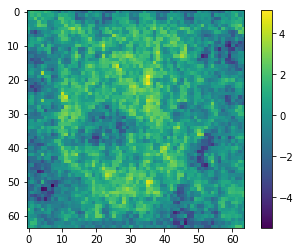

1551 [D loss: -1.597228] [G loss: -0.413094]
1552 [D loss: -1.683339] [G loss: -1.022066]
1553 [D loss: -1.975816] [G loss: -0.549300]
1554 [D loss: -1.694210] [G loss: 2.101561]
1555 [D loss: -1.117878] [G loss: -0.322463]
1556 [D loss: -0.264337] [G loss: 1.158957]
1557 [D loss: -0.150628] [G loss: 0.606962]
1558 [D loss: -0.099292] [G loss: -0.333689]
1559 [D loss: -0.073587] [G loss: -0.349199]
1560 [D loss: -0.057166] [G loss: -2.122850]
1561 [D loss: -0.619277] [G loss: -2.579351]
1562 [D loss: 0.264772] [G loss: -0.439063]
1563 [D loss: -0.119837] [G loss: -2.521151]
1564 [D loss: 0.642299] [G loss: -2.912130]
1565 [D loss: 1.165733] [G loss: -4.021155]
1566 [D loss: 1.316065] [G loss: -1.443217]
1567 [D loss: 1.427559] [G loss: 1.623787]
1568 [D loss: 0.661213] [G loss: 3.892814]
1569 [D loss: 1.338278] [G loss: 3.975243]
1570 [D loss: 0.744884] [G loss: 6.899155]
1571 [D loss: 1.009697] [G loss: 6.885922]
1572 [D loss: 0.232489] [G loss: 6.263591]
1573 [D loss: 0.194869] [G lo

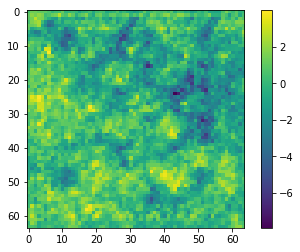

1601 [D loss: 2.302820] [G loss: 6.171043]
1602 [D loss: 2.452175] [G loss: 2.379711]
1603 [D loss: 1.813319] [G loss: 1.112752]
1604 [D loss: 1.350372] [G loss: 0.596157]
1605 [D loss: 0.311377] [G loss: -2.713617]
1606 [D loss: -1.447792] [G loss: -2.587984]
1607 [D loss: -2.196855] [G loss: -6.260678]
1608 [D loss: -2.547264] [G loss: -3.904083]
1609 [D loss: -1.739493] [G loss: -3.817695]
1610 [D loss: -1.685848] [G loss: -5.494204]
1611 [D loss: -1.424060] [G loss: -6.327260]
1612 [D loss: -1.175581] [G loss: -6.124709]
1613 [D loss: -0.635562] [G loss: -3.575651]
1614 [D loss: -0.886261] [G loss: -3.801443]
1615 [D loss: -0.048329] [G loss: -5.552023]
1616 [D loss: 0.420757] [G loss: -4.321446]
1617 [D loss: 0.702231] [G loss: -3.943354]
1618 [D loss: 0.863603] [G loss: 1.921758]
1619 [D loss: 0.996742] [G loss: 1.101719]
1620 [D loss: 0.873897] [G loss: 2.163996]
1621 [D loss: 1.283327] [G loss: 2.810601]
1622 [D loss: 2.702477] [G loss: -1.736848]
1623 [D loss: 2.320562] [G los

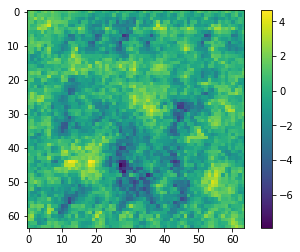

1651 [D loss: 0.066542] [G loss: -4.815500]
1652 [D loss: -0.352835] [G loss: -5.568151]
1653 [D loss: 0.293003] [G loss: -3.411899]
1654 [D loss: 0.383708] [G loss: -4.694678]
1655 [D loss: -0.079946] [G loss: -3.222056]
1656 [D loss: -0.220644] [G loss: -4.874181]
1657 [D loss: -0.480595] [G loss: -5.444484]
1658 [D loss: 0.801009] [G loss: -4.710633]
1659 [D loss: 0.021805] [G loss: -0.475335]
1660 [D loss: -0.644174] [G loss: 1.206618]
1661 [D loss: 0.230259] [G loss: -4.615396]
1662 [D loss: -0.622353] [G loss: -7.137755]
1663 [D loss: -0.573458] [G loss: -8.231268]
1664 [D loss: 0.246792] [G loss: -7.857041]
1665 [D loss: 0.037489] [G loss: -7.135822]
1666 [D loss: 0.356712] [G loss: -6.457030]
1667 [D loss: -0.244392] [G loss: -7.083528]
1668 [D loss: 0.292989] [G loss: -6.481789]
1669 [D loss: 0.419517] [G loss: -9.010179]
1670 [D loss: 0.724822] [G loss: -6.757098]
1671 [D loss: 1.033996] [G loss: -5.221348]
1672 [D loss: 1.305660] [G loss: -2.494867]
1673 [D loss: -0.758269] 

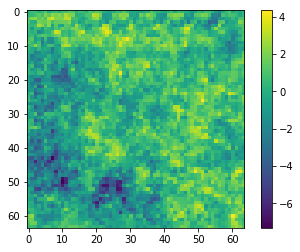

1701 [D loss: -0.891347] [G loss: -2.089712]
1702 [D loss: -0.604931] [G loss: -1.452849]
1703 [D loss: -0.925503] [G loss: -2.586967]
1704 [D loss: -0.760953] [G loss: -1.257160]
1705 [D loss: -0.662645] [G loss: -0.753203]
1706 [D loss: -1.319514] [G loss: 1.504878]
1707 [D loss: -1.725981] [G loss: 2.946331]
1708 [D loss: -1.365315] [G loss: -1.575337]
1709 [D loss: -0.742876] [G loss: -4.183863]
1710 [D loss: -0.394276] [G loss: -4.090275]
1711 [D loss: 0.456401] [G loss: -4.665690]
1712 [D loss: 0.277562] [G loss: -5.703717]
1713 [D loss: 0.071185] [G loss: -6.333493]
1714 [D loss: -0.299888] [G loss: -3.293064]
1715 [D loss: -0.451076] [G loss: -3.123570]
1716 [D loss: 0.140860] [G loss: -0.173593]
1717 [D loss: 0.130137] [G loss: 1.670030]
1718 [D loss: 0.555113] [G loss: 3.348573]
1719 [D loss: -0.291977] [G loss: 1.190718]
1720 [D loss: 0.153409] [G loss: -2.214056]
1721 [D loss: -0.046417] [G loss: -1.153815]
1722 [D loss: 0.128502] [G loss: -1.434301]
1723 [D loss: 0.281539]

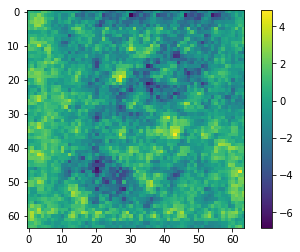

1751 [D loss: -1.577248] [G loss: 4.410641]
1752 [D loss: -1.121303] [G loss: 5.023387]
1753 [D loss: -1.071792] [G loss: 5.240906]
1754 [D loss: -0.148830] [G loss: 4.351277]
1755 [D loss: -0.175919] [G loss: 3.194817]
1756 [D loss: -0.827156] [G loss: 2.393244]
1757 [D loss: -0.446220] [G loss: 0.728139]
1758 [D loss: -0.923603] [G loss: 0.864225]
1759 [D loss: -0.683335] [G loss: 0.015979]
1760 [D loss: -0.691213] [G loss: 0.259236]
1761 [D loss: -0.588165] [G loss: 0.906329]
1762 [D loss: -0.938775] [G loss: -0.640439]
1763 [D loss: -2.007249] [G loss: -1.493825]
1764 [D loss: -2.436871] [G loss: -1.791943]
1765 [D loss: -2.932991] [G loss: -1.304899]
1766 [D loss: -3.033328] [G loss: -0.047858]
1767 [D loss: -2.520263] [G loss: 0.049725]
1768 [D loss: -2.369353] [G loss: -1.746510]
1769 [D loss: -1.027529] [G loss: -0.713724]
1770 [D loss: -0.830161] [G loss: 1.384063]
1771 [D loss: 0.208055] [G loss: 0.959798]
1772 [D loss: -0.157339] [G loss: -1.904106]
1773 [D loss: -0.177546] 

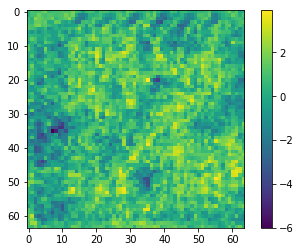

1801 [D loss: -0.118075] [G loss: 6.799596]
1802 [D loss: 1.668364] [G loss: 6.332093]
1803 [D loss: 1.530240] [G loss: 7.020859]
1804 [D loss: 0.188079] [G loss: 5.861578]
1805 [D loss: -0.891110] [G loss: 3.949558]
1806 [D loss: -0.975184] [G loss: -0.510484]
1807 [D loss: -0.563316] [G loss: -7.272093]
1808 [D loss: -0.320696] [G loss: -7.168073]
1809 [D loss: -0.424662] [G loss: -6.512993]
1810 [D loss: 0.199674] [G loss: -6.353417]
1811 [D loss: 0.801627] [G loss: -5.831460]
1812 [D loss: 0.836015] [G loss: -4.279258]
1813 [D loss: 0.133685] [G loss: -2.552082]
1814 [D loss: 0.155536] [G loss: -0.915733]
1815 [D loss: 0.611543] [G loss: 2.446174]
1816 [D loss: 0.440213] [G loss: 1.679107]
1817 [D loss: -0.107118] [G loss: 0.293514]
1818 [D loss: -0.572105] [G loss: -2.064375]
1819 [D loss: -1.213406] [G loss: -3.797576]
1820 [D loss: -1.340810] [G loss: -2.702211]
1821 [D loss: -0.611737] [G loss: -4.946609]
1822 [D loss: -2.103940] [G loss: -4.573802]
1823 [D loss: -0.991198] [G 

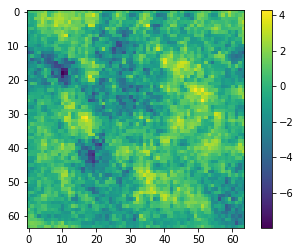

1851 [D loss: -2.289101] [G loss: 3.966200]
1852 [D loss: -2.006943] [G loss: 4.296836]
1853 [D loss: -1.546235] [G loss: 3.374144]
1854 [D loss: -2.256428] [G loss: 1.924973]
1855 [D loss: -0.944347] [G loss: 3.361720]
1856 [D loss: -1.785795] [G loss: 1.226589]
1857 [D loss: -1.084333] [G loss: 0.790103]
1858 [D loss: -1.143246] [G loss: -1.476073]
1859 [D loss: -0.905823] [G loss: -0.808866]
1860 [D loss: 0.257253] [G loss: -1.076978]
1861 [D loss: 0.180818] [G loss: -4.728230]
1862 [D loss: 0.826627] [G loss: -3.444723]
1863 [D loss: 0.496489] [G loss: -7.094888]
1864 [D loss: 0.466990] [G loss: -4.839540]
1865 [D loss: -0.060320] [G loss: -5.905642]
1866 [D loss: -0.093601] [G loss: -4.702136]
1867 [D loss: 1.175936] [G loss: -6.084544]
1868 [D loss: -0.832957] [G loss: -6.865049]
1869 [D loss: -0.014878] [G loss: -5.075585]
1870 [D loss: -0.348618] [G loss: -3.461417]
1871 [D loss: -0.498942] [G loss: -0.204941]
1872 [D loss: -0.320001] [G loss: 3.545852]
1873 [D loss: -0.715126]

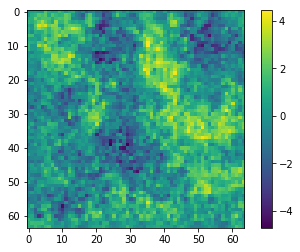

1901 [D loss: 0.818767] [G loss: -5.124173]
1902 [D loss: 0.196646] [G loss: -6.530449]
1903 [D loss: -0.069707] [G loss: -5.547516]
1904 [D loss: 0.206334] [G loss: -7.559599]
1905 [D loss: 0.285966] [G loss: -7.462602]
1906 [D loss: 0.152610] [G loss: -7.908494]
1907 [D loss: 0.739383] [G loss: -7.055826]
1908 [D loss: -0.037302] [G loss: -5.169375]
1909 [D loss: -0.138901] [G loss: -2.543505]
1910 [D loss: -0.864289] [G loss: -0.524419]
1911 [D loss: 0.826793] [G loss: -3.609802]
1912 [D loss: 1.030744] [G loss: 0.727099]
1913 [D loss: 0.715240] [G loss: 0.683823]
1914 [D loss: 0.857116] [G loss: 3.180543]
1915 [D loss: 1.310674] [G loss: 6.094996]
1916 [D loss: 0.383536] [G loss: 1.498400]
1917 [D loss: -0.750463] [G loss: -4.642553]
1918 [D loss: -0.758223] [G loss: -1.021482]
1919 [D loss: -0.762300] [G loss: -2.053556]
1920 [D loss: -0.494387] [G loss: -3.320354]
1921 [D loss: -0.690238] [G loss: -7.508441]
1922 [D loss: 0.377079] [G loss: -5.215791]
1923 [D loss: 0.125776] [G l

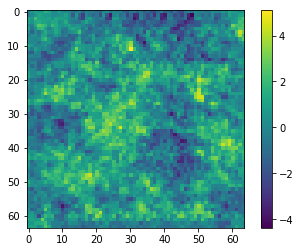

1951 [D loss: 1.318686] [G loss: 3.839167]
1952 [D loss: 1.017271] [G loss: 6.122021]
1953 [D loss: -0.036007] [G loss: 3.932366]
1954 [D loss: 1.059722] [G loss: -0.587721]
1955 [D loss: -1.666636] [G loss: -2.810821]
1956 [D loss: -0.627886] [G loss: -3.438322]
1957 [D loss: -1.162146] [G loss: -4.266426]
1958 [D loss: -1.520759] [G loss: -1.676146]
1959 [D loss: -1.361812] [G loss: 1.018331]
1960 [D loss: -0.700765] [G loss: 4.112435]
1961 [D loss: -1.326570] [G loss: 2.712314]
1962 [D loss: 0.767917] [G loss: 3.513309]
1963 [D loss: -0.653521] [G loss: 5.286903]
1964 [D loss: 0.265107] [G loss: 5.591973]
1965 [D loss: -0.507062] [G loss: 7.578289]
1966 [D loss: -0.197041] [G loss: 4.356690]
1967 [D loss: -0.631287] [G loss: 3.004752]
1968 [D loss: -1.571308] [G loss: 1.825526]
1969 [D loss: -0.302257] [G loss: 0.271890]
1970 [D loss: -0.843226] [G loss: 5.013936]
1971 [D loss: 1.141436] [G loss: -1.495797]
1972 [D loss: -0.263796] [G loss: -0.747641]
1973 [D loss: 0.260556] [G loss

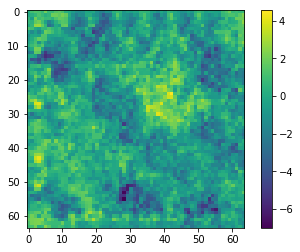

2001 [D loss: -0.480497] [G loss: 4.196568]
2002 [D loss: -0.414936] [G loss: 2.309467]
2003 [D loss: -1.047004] [G loss: 6.998283]
2004 [D loss: -0.081291] [G loss: 6.795259]
2005 [D loss: -0.462204] [G loss: 6.415120]
2006 [D loss: -0.180100] [G loss: 5.061524]
2007 [D loss: -1.074313] [G loss: 2.571603]
2008 [D loss: 0.088681] [G loss: 2.953094]
2009 [D loss: -0.471012] [G loss: 4.693611]
2010 [D loss: -0.724257] [G loss: 6.412266]
2011 [D loss: -1.054575] [G loss: 6.557311]
2012 [D loss: -0.950582] [G loss: 6.099346]
2013 [D loss: -0.497841] [G loss: 6.479246]
2014 [D loss: -0.764730] [G loss: 5.244847]
2015 [D loss: -1.082716] [G loss: 3.628750]
2016 [D loss: -0.480308] [G loss: 0.349583]
2017 [D loss: -1.846956] [G loss: 2.353986]
2018 [D loss: -1.152002] [G loss: 2.144854]
2019 [D loss: -0.493465] [G loss: -0.255214]
2020 [D loss: -1.423795] [G loss: -0.746380]
2021 [D loss: -0.779299] [G loss: 0.559223]
2022 [D loss: -0.725530] [G loss: 2.261432]
2023 [D loss: -1.744251] [G los

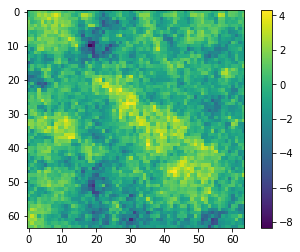

2051 [D loss: -0.989838] [G loss: -2.974220]
2052 [D loss: -0.602929] [G loss: -0.375824]
2053 [D loss: 0.289269] [G loss: 1.989124]
2054 [D loss: -0.114538] [G loss: 0.427829]
2055 [D loss: -0.301605] [G loss: 4.166288]
2056 [D loss: 0.837477] [G loss: 5.527154]
2057 [D loss: 0.161281] [G loss: 6.769297]
2058 [D loss: -0.204074] [G loss: 8.489855]
2059 [D loss: -0.267254] [G loss: 8.190477]
2060 [D loss: 0.755509] [G loss: 6.359833]
2061 [D loss: 0.869011] [G loss: 5.333188]
2062 [D loss: 0.207872] [G loss: 4.855615]
2063 [D loss: -0.171331] [G loss: 8.565279]
2064 [D loss: 0.325720] [G loss: -3.349171]
2065 [D loss: -0.547509] [G loss: -4.588328]
2066 [D loss: -0.696975] [G loss: -3.460949]
2067 [D loss: -1.901075] [G loss: -4.785752]
2068 [D loss: -1.277918] [G loss: -5.067743]
2069 [D loss: -0.625062] [G loss: -0.669933]
2070 [D loss: -0.918845] [G loss: -2.209763]
2071 [D loss: -1.007384] [G loss: -0.446197]
2072 [D loss: -1.852783] [G loss: -2.731710]
2073 [D loss: -0.781017] [G 

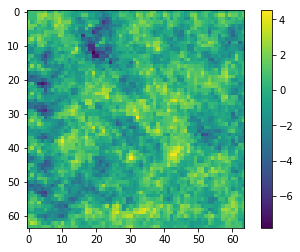

2101 [D loss: -0.083209] [G loss: 6.373243]
2102 [D loss: -0.043478] [G loss: 4.731612]
2103 [D loss: 0.330841] [G loss: -0.161192]
2104 [D loss: -1.049736] [G loss: 3.788070]
2105 [D loss: -0.115373] [G loss: 1.814313]
2106 [D loss: 0.109710] [G loss: -0.068090]
2107 [D loss: 0.559076] [G loss: 4.515210]
2108 [D loss: 0.072474] [G loss: 5.045955]
2109 [D loss: -0.441749] [G loss: 2.544774]
2110 [D loss: -0.428126] [G loss: 0.846220]
2111 [D loss: -0.358429] [G loss: 1.206978]
2112 [D loss: -1.025526] [G loss: 5.367873]
2113 [D loss: -0.064290] [G loss: 4.817093]
2114 [D loss: -0.952287] [G loss: 5.393070]
2115 [D loss: -0.326490] [G loss: 4.339417]
2116 [D loss: -0.771323] [G loss: 6.144339]
2117 [D loss: 0.416102] [G loss: 2.645305]
2118 [D loss: -0.863259] [G loss: 4.258086]
2119 [D loss: -0.006080] [G loss: -3.103872]
2120 [D loss: -0.949396] [G loss: -1.305720]
2121 [D loss: -0.655223] [G loss: -5.442567]
2122 [D loss: -0.315048] [G loss: -5.499922]
2123 [D loss: -0.140107] [G los

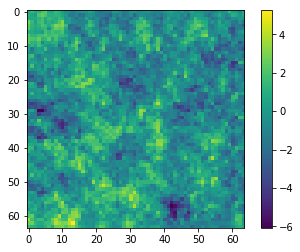

2151 [D loss: -1.003160] [G loss: -1.726583]
2152 [D loss: -1.690504] [G loss: 2.607686]
2153 [D loss: 0.301800] [G loss: 3.383868]
2154 [D loss: 0.918650] [G loss: 6.013289]
2155 [D loss: 0.328128] [G loss: 6.661664]
2156 [D loss: 0.129862] [G loss: 9.259714]
2157 [D loss: 1.288536] [G loss: 7.088305]
2158 [D loss: 0.632065] [G loss: 7.977389]
2159 [D loss: -0.474911] [G loss: 10.145212]
2160 [D loss: 1.046073] [G loss: 6.137668]
2161 [D loss: -1.007397] [G loss: 7.421499]
2162 [D loss: -1.604762] [G loss: 6.087493]
2163 [D loss: -1.524150] [G loss: 5.936489]
2164 [D loss: -1.415818] [G loss: 0.020450]
2165 [D loss: -1.906207] [G loss: 0.127450]
2166 [D loss: -1.211109] [G loss: 1.188673]
2167 [D loss: -0.857915] [G loss: 1.395603]
2168 [D loss: -0.762573] [G loss: 3.565355]
2169 [D loss: 0.186952] [G loss: 3.524625]
2170 [D loss: 0.977571] [G loss: 5.121667]
2171 [D loss: 0.042627] [G loss: 0.026302]
2172 [D loss: -0.944255] [G loss: -2.331459]
2173 [D loss: -1.470687] [G loss: -0.90

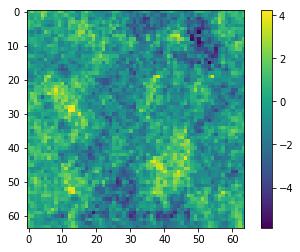

2201 [D loss: -0.631695] [G loss: 4.519449]
2202 [D loss: 0.092929] [G loss: 0.182039]
2203 [D loss: 0.207944] [G loss: 3.657592]
2204 [D loss: -0.207478] [G loss: 8.431612]
2205 [D loss: 0.710308] [G loss: 3.694645]
2206 [D loss: -0.374671] [G loss: 5.743932]
2207 [D loss: -0.430176] [G loss: 3.486591]
2208 [D loss: -0.716921] [G loss: -0.027762]
2209 [D loss: -0.251755] [G loss: 2.758025]
2210 [D loss: -0.126890] [G loss: 2.964593]
2211 [D loss: -0.146363] [G loss: 5.046307]
2212 [D loss: -0.470116] [G loss: 5.745135]
2213 [D loss: 0.023993] [G loss: 6.749210]
2214 [D loss: -0.290225] [G loss: 9.594669]
2215 [D loss: 1.133520] [G loss: 6.434070]
2216 [D loss: 0.966679] [G loss: 7.940565]
2217 [D loss: 1.034449] [G loss: 5.300954]
2218 [D loss: -0.318826] [G loss: 8.390662]
2219 [D loss: 0.205868] [G loss: 7.004856]
2220 [D loss: 0.118934] [G loss: 8.602873]
2221 [D loss: 0.925820] [G loss: 7.383196]
2222 [D loss: 0.973197] [G loss: 8.576952]
2223 [D loss: 0.795474] [G loss: 9.450851]

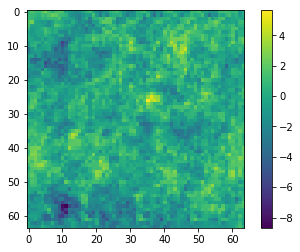

2251 [D loss: 0.601446] [G loss: 8.717521]
2252 [D loss: 0.561309] [G loss: 9.366924]
2253 [D loss: 0.105035] [G loss: 9.125154]
2254 [D loss: 0.367827] [G loss: 8.716288]
2255 [D loss: 0.817686] [G loss: 10.300670]
2256 [D loss: 0.959126] [G loss: 8.904767]
2257 [D loss: 2.312192] [G loss: 8.767965]
2258 [D loss: 1.391891] [G loss: 9.253330]
2259 [D loss: 1.554757] [G loss: 9.762551]
2260 [D loss: 2.147214] [G loss: 8.324667]
2261 [D loss: 2.528275] [G loss: 7.944593]
2262 [D loss: 2.448207] [G loss: 8.643777]
2263 [D loss: 1.777972] [G loss: 8.617943]
2264 [D loss: 2.301503] [G loss: 7.750669]
2265 [D loss: 2.208973] [G loss: 6.437132]
2266 [D loss: 2.738797] [G loss: 5.349054]
2267 [D loss: 2.938601] [G loss: 4.707009]
2268 [D loss: 1.377775] [G loss: 3.496778]
2269 [D loss: -2.399229] [G loss: 2.708106]
2270 [D loss: -3.538774] [G loss: -5.341026]
2271 [D loss: -2.923821] [G loss: -4.855116]
2272 [D loss: -3.066487] [G loss: -6.084838]
2273 [D loss: -2.885181] [G loss: -7.744168]
2

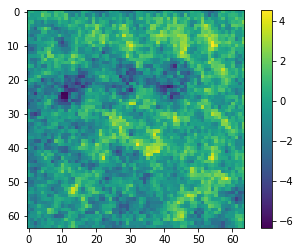

2301 [D loss: 1.356380] [G loss: 4.822358]
2302 [D loss: -0.142044] [G loss: 3.629655]
2303 [D loss: -0.654978] [G loss: 3.677808]
2304 [D loss: -0.675026] [G loss: -4.759619]
2305 [D loss: -1.228528] [G loss: -3.420706]
2306 [D loss: -1.489883] [G loss: -0.066112]
2307 [D loss: -0.315695] [G loss: -0.886786]
2308 [D loss: -0.791158] [G loss: 5.231280]
2309 [D loss: -0.136313] [G loss: 6.027954]
2310 [D loss: 0.303952] [G loss: 4.380891]
2311 [D loss: 0.508779] [G loss: 5.564625]
2312 [D loss: 0.954652] [G loss: 6.248760]
2313 [D loss: 0.265111] [G loss: 1.829718]
2314 [D loss: -0.579453] [G loss: 2.556855]
2315 [D loss: -0.900685] [G loss: 1.993677]
2316 [D loss: -1.750304] [G loss: 3.100190]
2317 [D loss: -1.590042] [G loss: -1.943467]
2318 [D loss: -2.066854] [G loss: -3.672316]
2319 [D loss: -0.222711] [G loss: -7.846129]
2320 [D loss: -1.208637] [G loss: -6.361337]
2321 [D loss: -0.706749] [G loss: -4.857695]
2322 [D loss: -1.327059] [G loss: -5.897069]
2323 [D loss: -1.032237] [G

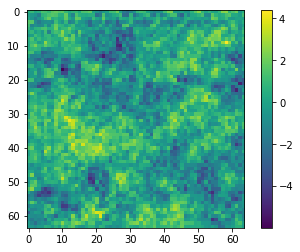

2351 [D loss: 1.196533] [G loss: -3.510987]
2352 [D loss: -0.654602] [G loss: -0.608396]
2353 [D loss: -1.378733] [G loss: -1.363360]
2354 [D loss: -1.161692] [G loss: -5.042561]
2355 [D loss: -0.116337] [G loss: -6.441112]
2356 [D loss: -0.216372] [G loss: -7.770108]
2357 [D loss: 0.117859] [G loss: -8.680622]
2358 [D loss: -0.288778] [G loss: -7.279541]
2359 [D loss: -0.034460] [G loss: -3.646567]
2360 [D loss: -0.737121] [G loss: 3.762748]
2361 [D loss: -1.188301] [G loss: 1.605204]
2362 [D loss: -2.052065] [G loss: 1.290752]
2363 [D loss: -2.607432] [G loss: 1.680638]
2364 [D loss: -3.164198] [G loss: 0.838461]
2365 [D loss: -2.084513] [G loss: -0.820611]
2366 [D loss: -1.678612] [G loss: -2.191282]
2367 [D loss: -0.872619] [G loss: 3.187268]
2368 [D loss: -1.674163] [G loss: 1.051008]
2369 [D loss: -0.970592] [G loss: 1.099151]
2370 [D loss: -0.519024] [G loss: 0.549103]
2371 [D loss: -0.358530] [G loss: 2.267490]
2372 [D loss: -0.399941] [G loss: 4.371702]
2373 [D loss: -0.441745

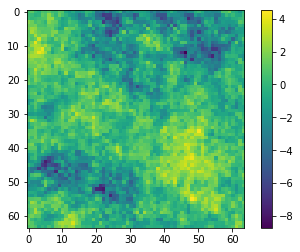

2401 [D loss: -0.327171] [G loss: -1.579348]
2402 [D loss: -0.526189] [G loss: -1.624549]
2403 [D loss: -1.299310] [G loss: -0.334278]
2404 [D loss: -0.852654] [G loss: 4.119385]
2405 [D loss: -0.813592] [G loss: 3.999893]
2406 [D loss: -0.870709] [G loss: 7.562603]
2407 [D loss: -0.852608] [G loss: 7.402605]
2408 [D loss: 0.468786] [G loss: 8.426043]
2409 [D loss: 0.515671] [G loss: 7.014516]
2410 [D loss: 0.678617] [G loss: 7.577776]
2411 [D loss: 0.910188] [G loss: 6.333670]
2412 [D loss: 0.436654] [G loss: 7.240216]
2413 [D loss: 0.639266] [G loss: 1.081287]
2414 [D loss: 0.120716] [G loss: -0.205365]
2415 [D loss: -0.292697] [G loss: 4.672133]
2416 [D loss: -0.407012] [G loss: 5.909868]
2417 [D loss: 0.111397] [G loss: 7.352184]
2418 [D loss: 0.237873] [G loss: 8.107723]
2419 [D loss: -0.141309] [G loss: 4.880882]
2420 [D loss: -0.143826] [G loss: -2.293197]
2421 [D loss: -0.948956] [G loss: -2.858035]
2422 [D loss: 0.336040] [G loss: -7.339000]
2423 [D loss: 0.159329] [G loss: -5

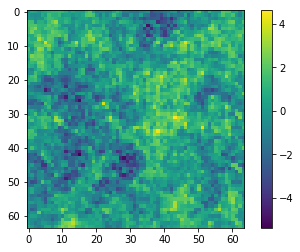

2451 [D loss: 0.590350] [G loss: -5.809648]
2452 [D loss: 0.123213] [G loss: -6.145990]
2453 [D loss: 0.547405] [G loss: -0.735336]
2454 [D loss: -0.785925] [G loss: -2.250493]
2455 [D loss: -1.046794] [G loss: -0.452527]
2456 [D loss: -0.663089] [G loss: -0.339636]
2457 [D loss: -0.308498] [G loss: -4.735746]
2458 [D loss: -0.367845] [G loss: 2.114126]
2459 [D loss: 0.560021] [G loss: -1.227449]
2460 [D loss: -0.248134] [G loss: 2.049604]
2461 [D loss: 0.837211] [G loss: 3.609737]
2462 [D loss: 0.307512] [G loss: 1.172390]
2463 [D loss: 0.298267] [G loss: -2.951079]
2464 [D loss: -0.742194] [G loss: -3.968886]
2465 [D loss: -1.215867] [G loss: -7.790917]
2466 [D loss: 0.078547] [G loss: -8.593183]
2467 [D loss: 0.061094] [G loss: -2.824379]
2468 [D loss: 0.780509] [G loss: -0.035962]
2469 [D loss: 0.005261] [G loss: 1.479119]
2470 [D loss: -0.412593] [G loss: -2.007887]
2471 [D loss: 0.423515] [G loss: 1.750498]
2472 [D loss: 0.133030] [G loss: 6.033488]
2473 [D loss: -0.115923] [G lo

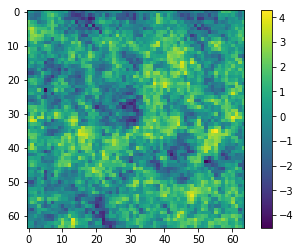

2501 [D loss: 1.963173] [G loss: -8.865377]
2502 [D loss: -0.092142] [G loss: -8.488199]
2503 [D loss: -1.244599] [G loss: -0.576733]
2504 [D loss: -1.467297] [G loss: -2.151289]
2505 [D loss: -0.523823] [G loss: -2.528225]
2506 [D loss: -0.389009] [G loss: -3.896476]
2507 [D loss: -1.304684] [G loss: 2.963640]
2508 [D loss: 0.968025] [G loss: -0.723429]
2509 [D loss: 0.733542] [G loss: -2.994746]
2510 [D loss: 0.204738] [G loss: -4.065931]
2511 [D loss: 0.903269] [G loss: -3.165852]
2512 [D loss: -0.238539] [G loss: 5.481224]
2513 [D loss: -1.551123] [G loss: 2.003870]
2514 [D loss: -1.368792] [G loss: 5.094134]
2515 [D loss: -1.563655] [G loss: 6.768381]
2516 [D loss: -1.052254] [G loss: 2.389879]
2517 [D loss: -0.951792] [G loss: 3.571689]
2518 [D loss: -0.304689] [G loss: 0.682428]
2519 [D loss: -0.360405] [G loss: 2.824239]
2520 [D loss: 0.011176] [G loss: 3.207368]
2521 [D loss: -0.307012] [G loss: 5.642531]
2522 [D loss: 0.600029] [G loss: 7.489803]
2523 [D loss: -0.010530] [G l

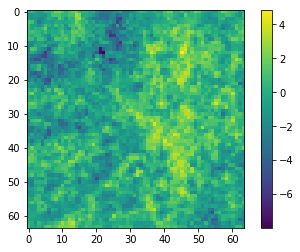

2551 [D loss: -1.586557] [G loss: 4.122810]
2552 [D loss: -0.909945] [G loss: -1.783995]
2553 [D loss: -0.382550] [G loss: -2.564881]
2554 [D loss: -1.040251] [G loss: -4.322170]
2555 [D loss: -0.523574] [G loss: -1.590498]
2556 [D loss: 0.070445] [G loss: -2.106454]
2557 [D loss: 0.145199] [G loss: -4.132579]
2558 [D loss: 0.032413] [G loss: 2.627558]
2559 [D loss: -0.876510] [G loss: 0.022936]
2560 [D loss: -1.348797] [G loss: -0.423715]
2561 [D loss: -0.565409] [G loss: -1.410459]
2562 [D loss: 0.517420] [G loss: -4.040622]
2563 [D loss: -0.075757] [G loss: 3.107012]
2564 [D loss: 0.339899] [G loss: -0.031416]
2565 [D loss: -0.470398] [G loss: 0.098731]
2566 [D loss: 0.112905] [G loss: 3.643950]
2567 [D loss: 0.109894] [G loss: -1.219617]
2568 [D loss: -0.664838] [G loss: -0.704349]
2569 [D loss: 0.200331] [G loss: 6.083777]
2570 [D loss: 0.045004] [G loss: -3.673412]
2571 [D loss: 0.904251] [G loss: -4.074500]
2572 [D loss: -0.129284] [G loss: -0.455769]
2573 [D loss: 0.634012] [G 

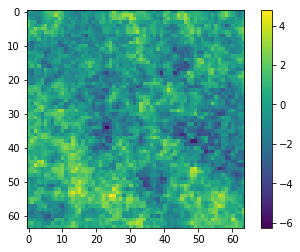

2601 [D loss: 0.548141] [G loss: -3.927030]
2602 [D loss: 0.548922] [G loss: -4.586880]
2603 [D loss: 0.110594] [G loss: -5.264577]
2604 [D loss: 0.181835] [G loss: -6.436988]
2605 [D loss: 0.486766] [G loss: -6.594207]
2606 [D loss: 0.282969] [G loss: -4.098506]
2607 [D loss: -1.603469] [G loss: -0.556538]
2608 [D loss: -1.298409] [G loss: 1.104388]
2609 [D loss: -1.689957] [G loss: 0.871912]
2610 [D loss: -1.090257] [G loss: -1.186975]
2611 [D loss: 0.164634] [G loss: 2.452147]
2612 [D loss: -1.093339] [G loss: 2.870780]
2613 [D loss: -0.241788] [G loss: 5.631341]
2614 [D loss: 0.221000] [G loss: 3.234126]
2615 [D loss: 1.283561] [G loss: 0.195156]
2616 [D loss: 0.515845] [G loss: 2.373911]
2617 [D loss: 0.468982] [G loss: 4.807117]
2618 [D loss: -0.213807] [G loss: 6.180274]
2619 [D loss: -0.452760] [G loss: 1.767879]
2620 [D loss: -0.407554] [G loss: -0.409460]
2621 [D loss: -0.079575] [G loss: 1.797901]
2622 [D loss: 0.296422] [G loss: 1.654367]
2623 [D loss: 0.359158] [G loss: 5.

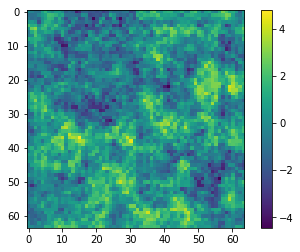

2651 [D loss: 0.215955] [G loss: -1.514817]
2652 [D loss: -0.921371] [G loss: -1.969846]
2653 [D loss: -1.835280] [G loss: -4.400366]
2654 [D loss: -1.535025] [G loss: -0.964116]
2655 [D loss: -0.962272] [G loss: -0.398488]
2656 [D loss: -0.270292] [G loss: 1.421464]
2657 [D loss: -0.650909] [G loss: 0.773310]
2658 [D loss: 0.504121] [G loss: -1.236531]
2659 [D loss: -0.115010] [G loss: -1.382210]
2660 [D loss: 0.050622] [G loss: -2.116435]
2661 [D loss: -0.485166] [G loss: -3.184354]
2662 [D loss: 0.598313] [G loss: -1.748480]
2663 [D loss: -0.085359] [G loss: -1.945192]
2664 [D loss: -0.690347] [G loss: -0.367596]
2665 [D loss: 0.163107] [G loss: -1.552706]
2666 [D loss: -0.450182] [G loss: 4.351270]
2667 [D loss: 0.406371] [G loss: 2.462620]
2668 [D loss: -0.229197] [G loss: 6.063876]
2669 [D loss: 0.242044] [G loss: 5.582868]
2670 [D loss: -0.556937] [G loss: 2.439523]
2671 [D loss: 0.235589] [G loss: 4.742250]
2672 [D loss: -0.507076] [G loss: 7.935434]
2673 [D loss: -0.071834] [G

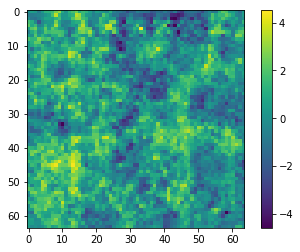

2701 [D loss: -0.079563] [G loss: -2.184632]
2702 [D loss: -0.778615] [G loss: -0.648517]
2703 [D loss: -0.033806] [G loss: 1.564870]
2704 [D loss: -0.177328] [G loss: 8.249598]
2705 [D loss: -0.180099] [G loss: 5.083349]
2706 [D loss: -0.217463] [G loss: 5.359764]
2707 [D loss: -0.906623] [G loss: -4.183339]
2708 [D loss: -0.960237] [G loss: -3.310111]
2709 [D loss: -0.063856] [G loss: -2.898020]
2710 [D loss: -0.665512] [G loss: 1.912394]
2711 [D loss: -0.131806] [G loss: -0.768422]
2712 [D loss: -0.474700] [G loss: 0.960797]
2713 [D loss: -0.968417] [G loss: -0.140657]
2714 [D loss: -0.478302] [G loss: 5.405748]
2715 [D loss: -0.864192] [G loss: 2.364920]
2716 [D loss: -0.679463] [G loss: 5.530137]
2717 [D loss: 0.513521] [G loss: 1.867730]
2718 [D loss: -0.226218] [G loss: 6.358006]
2719 [D loss: -0.413164] [G loss: -0.300038]
2720 [D loss: -0.973070] [G loss: -5.899245]
2721 [D loss: -0.662165] [G loss: -0.746352]
2722 [D loss: -0.389993] [G loss: -3.705941]
2723 [D loss: 0.459343

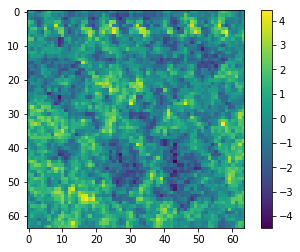

2751 [D loss: 0.248386] [G loss: 8.036198]
2752 [D loss: -0.682908] [G loss: 7.974039]
2753 [D loss: 1.183206] [G loss: 8.815914]
2754 [D loss: -0.230895] [G loss: 5.685400]
2755 [D loss: 0.049915] [G loss: 3.622806]
2756 [D loss: 0.368839] [G loss: 4.760022]
2757 [D loss: -0.018932] [G loss: 3.399145]
2758 [D loss: -0.313244] [G loss: 3.928158]
2759 [D loss: 0.273608] [G loss: 3.767341]
2760 [D loss: 0.086597] [G loss: 5.750628]
2761 [D loss: -1.565013] [G loss: 3.193324]
2762 [D loss: -2.186413] [G loss: 2.968555]
2763 [D loss: -1.655697] [G loss: 2.632200]
2764 [D loss: -2.220022] [G loss: 1.777675]
2765 [D loss: -2.194391] [G loss: -0.622248]
2766 [D loss: -0.992871] [G loss: 5.778278]
2767 [D loss: -0.633880] [G loss: 4.737989]
2768 [D loss: 0.147966] [G loss: 0.130508]
2769 [D loss: 1.092398] [G loss: -0.581058]
2770 [D loss: 0.859099] [G loss: 3.941986]
2771 [D loss: 0.716835] [G loss: 0.676664]
2772 [D loss: 0.941145] [G loss: 5.028460]
2773 [D loss: 1.596116] [G loss: 6.059888

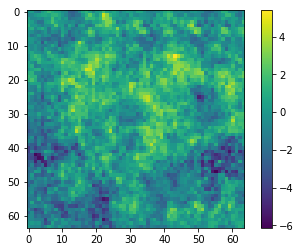

2801 [D loss: -0.280303] [G loss: -8.209654]
2802 [D loss: 0.257089] [G loss: -7.413782]
2803 [D loss: -0.910988] [G loss: -9.645223]
2804 [D loss: -0.713050] [G loss: -11.283335]
2805 [D loss: -0.095333] [G loss: -10.681095]
2806 [D loss: -0.491118] [G loss: -10.188601]
2807 [D loss: 0.014956] [G loss: -10.405735]
2808 [D loss: -0.580622] [G loss: -8.713099]
2809 [D loss: -0.571283] [G loss: -10.190601]
2810 [D loss: 0.276406] [G loss: -5.542370]
2811 [D loss: -0.051396] [G loss: -7.896842]
2812 [D loss: 0.510661] [G loss: -8.475257]
2813 [D loss: -0.424000] [G loss: -9.900160]
2814 [D loss: -0.542285] [G loss: -9.736669]
2815 [D loss: 0.858694] [G loss: -7.418478]
2816 [D loss: -0.035258] [G loss: -7.496756]
2817 [D loss: 0.323650] [G loss: -7.961861]
2818 [D loss: 0.372026] [G loss: -6.982989]
2819 [D loss: 0.606639] [G loss: -9.698538]
2820 [D loss: -0.219836] [G loss: -8.257761]
2821 [D loss: 0.568928] [G loss: -6.851380]
2822 [D loss: 0.247783] [G loss: -6.264090]
2823 [D loss: -

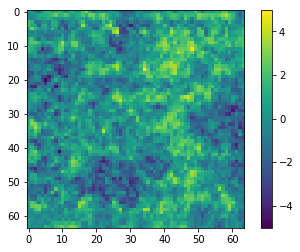

2851 [D loss: 0.206294] [G loss: 1.882599]
2852 [D loss: -0.003935] [G loss: 4.223593]
2853 [D loss: -1.361223] [G loss: 1.872874]
2854 [D loss: -2.201526] [G loss: 3.949646]
2855 [D loss: -1.561761] [G loss: 3.382515]
2856 [D loss: -0.142366] [G loss: -1.424339]
2857 [D loss: -1.048127] [G loss: 1.818783]
2858 [D loss: -0.077789] [G loss: 6.716062]
2859 [D loss: -0.357333] [G loss: 2.274570]
2860 [D loss: -1.611960] [G loss: -2.671351]
2861 [D loss: -0.479201] [G loss: -2.672682]
2862 [D loss: -1.241995] [G loss: -1.839688]
2863 [D loss: -1.389774] [G loss: -4.660926]
2864 [D loss: -0.512835] [G loss: -1.830584]
2865 [D loss: 0.299255] [G loss: 0.685747]
2866 [D loss: 0.688781] [G loss: -2.374957]
2867 [D loss: 0.955320] [G loss: 0.970110]
2868 [D loss: 1.318479] [G loss: 5.250677]
2869 [D loss: 1.528486] [G loss: -1.873377]
2870 [D loss: 0.165562] [G loss: -1.292568]
2871 [D loss: -0.212080] [G loss: -2.802720]
2872 [D loss: -0.827288] [G loss: -6.114355]
2873 [D loss: -0.349521] [G 

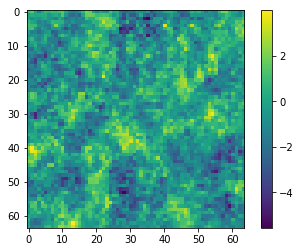

2901 [D loss: -0.655624] [G loss: -4.159857]
2902 [D loss: -1.406018] [G loss: -0.948254]
2903 [D loss: -1.335835] [G loss: 2.250725]
2904 [D loss: -0.261106] [G loss: 1.926509]
2905 [D loss: -1.439540] [G loss: 1.369642]
2906 [D loss: -0.072898] [G loss: 0.132471]
2907 [D loss: 0.834057] [G loss: -0.535842]
2908 [D loss: 1.491681] [G loss: -0.043715]
2909 [D loss: 2.021842] [G loss: -1.032492]
2910 [D loss: 1.192772] [G loss: 4.212650]
2911 [D loss: 1.055975] [G loss: 3.677842]
2912 [D loss: 1.337235] [G loss: 5.363686]
2913 [D loss: 1.485864] [G loss: 9.546813]
2914 [D loss: 0.414891] [G loss: 9.400231]
2915 [D loss: -0.459692] [G loss: 8.313394]
2916 [D loss: -1.052557] [G loss: 6.010138]
2917 [D loss: 1.082263] [G loss: 2.372156]
2918 [D loss: -0.453654] [G loss: -0.037122]
2919 [D loss: 0.068892] [G loss: -1.573518]
2920 [D loss: 0.551700] [G loss: -4.189027]
2921 [D loss: 1.418430] [G loss: -0.401963]
2922 [D loss: -0.801161] [G loss: -7.058760]
2923 [D loss: -0.465937] [G loss: 

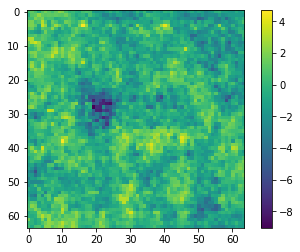

2951 [D loss: -0.124139] [G loss: -4.308802]
2952 [D loss: -0.134638] [G loss: -3.853724]
2953 [D loss: 0.104386] [G loss: -6.488256]
2954 [D loss: 0.464895] [G loss: -9.310976]
2955 [D loss: 0.381759] [G loss: -6.389417]
2956 [D loss: -0.363852] [G loss: -8.309868]
2957 [D loss: 0.120735] [G loss: -7.737864]
2958 [D loss: 0.139739] [G loss: -1.831739]
2959 [D loss: 0.298212] [G loss: -2.531817]
2960 [D loss: 0.296984] [G loss: -1.448358]
2961 [D loss: -0.605210] [G loss: 4.171405]
2962 [D loss: -1.104440] [G loss: 2.349388]
2963 [D loss: -0.325224] [G loss: 1.074687]
2964 [D loss: -0.460913] [G loss: 0.161058]
2965 [D loss: -0.355910] [G loss: -0.672804]
2966 [D loss: -1.006304] [G loss: -2.241920]
2967 [D loss: 0.289992] [G loss: 1.128919]
2968 [D loss: -0.964562] [G loss: 3.286244]
2969 [D loss: -1.082622] [G loss: 2.507324]
2970 [D loss: -0.502174] [G loss: -4.146328]
2971 [D loss: -0.890740] [G loss: -2.996866]
2972 [D loss: 0.976110] [G loss: -7.853225]
2973 [D loss: 1.326929] [G

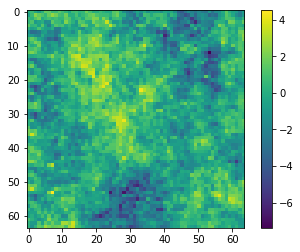

3001 [D loss: 1.848831] [G loss: 4.377936]
3002 [D loss: 0.631557] [G loss: 5.480858]
3003 [D loss: 1.038312] [G loss: 4.160606]
3004 [D loss: -0.139125] [G loss: -5.139381]
3005 [D loss: 0.297391] [G loss: -3.239849]
3006 [D loss: -0.024322] [G loss: -6.055182]
3007 [D loss: -1.158801] [G loss: -4.911008]
3008 [D loss: -1.119533] [G loss: -2.976697]
3009 [D loss: -0.783095] [G loss: -5.544527]
3010 [D loss: 0.113925] [G loss: -7.914204]
3011 [D loss: 0.662438] [G loss: -6.631701]
3012 [D loss: 1.823803] [G loss: -7.896366]
3013 [D loss: 0.471710] [G loss: -8.811138]
3014 [D loss: 0.966184] [G loss: -9.124409]
3015 [D loss: -0.572721] [G loss: -7.521968]
3016 [D loss: -0.834753] [G loss: -2.041318]
3017 [D loss: -0.908114] [G loss: -2.966564]
3018 [D loss: -0.354850] [G loss: -1.834416]
3019 [D loss: -1.233196] [G loss: -3.063966]
3020 [D loss: -1.314907] [G loss: -2.791965]
3021 [D loss: -0.316116] [G loss: -3.455958]
3022 [D loss: -0.712227] [G loss: -7.688638]
3023 [D loss: -0.06405

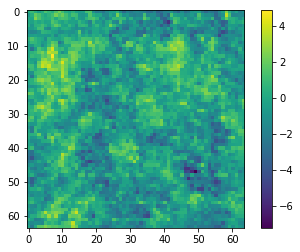

3051 [D loss: -0.468223] [G loss: 2.413716]
3052 [D loss: -0.655389] [G loss: -1.224936]
3053 [D loss: -0.710141] [G loss: 1.378704]
3054 [D loss: -0.607657] [G loss: 4.093957]
3055 [D loss: -1.088769] [G loss: 1.601751]
3056 [D loss: -0.742092] [G loss: 2.620878]
3057 [D loss: -0.975413] [G loss: 0.184854]
3058 [D loss: -0.080104] [G loss: -0.148029]
3059 [D loss: -1.557770] [G loss: -5.691212]
3060 [D loss: -0.092213] [G loss: -5.543641]
3061 [D loss: -0.910020] [G loss: -3.010452]
3062 [D loss: -0.908094] [G loss: -1.971338]
3063 [D loss: -0.962258] [G loss: -4.371704]
3064 [D loss: -0.735438] [G loss: -0.683757]
3065 [D loss: -1.376547] [G loss: -2.148633]
3066 [D loss: -1.444652] [G loss: -2.620553]
3067 [D loss: -2.093511] [G loss: -1.302499]
3068 [D loss: -1.011386] [G loss: -4.621899]
3069 [D loss: -1.575078] [G loss: -1.766465]
3070 [D loss: -1.843178] [G loss: 2.380168]
3071 [D loss: -0.570954] [G loss: 3.247125]
3072 [D loss: -0.252514] [G loss: 4.653193]
3073 [D loss: -0.45

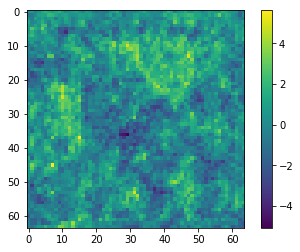

3101 [D loss: -0.058153] [G loss: -9.246788]
3102 [D loss: 0.573519] [G loss: -6.701800]
3103 [D loss: 0.788706] [G loss: -7.229468]
3104 [D loss: 0.789428] [G loss: -8.057141]
3105 [D loss: 1.279582] [G loss: -4.943277]
3106 [D loss: 0.173161] [G loss: 0.127425]
3107 [D loss: -0.697667] [G loss: 0.322666]
3108 [D loss: 0.184792] [G loss: -5.375516]
3109 [D loss: 0.157025] [G loss: -1.505628]
3110 [D loss: -0.917297] [G loss: -0.546155]
3111 [D loss: -0.904119] [G loss: -5.211084]
3112 [D loss: -0.113078] [G loss: -4.994875]
3113 [D loss: -0.491378] [G loss: -1.158208]
3114 [D loss: -0.768137] [G loss: -1.618372]
3115 [D loss: 0.256468] [G loss: -0.925221]
3116 [D loss: -1.020232] [G loss: -3.598847]
3117 [D loss: -0.596249] [G loss: -5.464862]
3118 [D loss: -1.144320] [G loss: -5.104009]
3119 [D loss: -1.542426] [G loss: 0.263010]
3120 [D loss: 0.169523] [G loss: -6.502967]
3121 [D loss: 0.038642] [G loss: -5.561899]
3122 [D loss: 0.559826] [G loss: -0.898639]
3123 [D loss: 0.239689] 

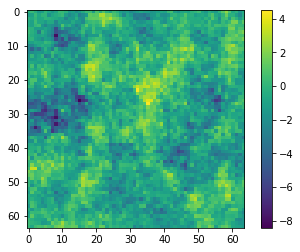

3151 [D loss: 1.844272] [G loss: 10.139227]
3152 [D loss: 1.628820] [G loss: 1.863908]
3153 [D loss: 1.916480] [G loss: -4.866989]
3154 [D loss: 1.261542] [G loss: -2.314033]
3155 [D loss: 1.011549] [G loss: -0.716842]
3156 [D loss: -0.509392] [G loss: -3.267036]
3157 [D loss: -1.500412] [G loss: -4.580276]
3158 [D loss: -2.115605] [G loss: -7.499990]
3159 [D loss: -0.091996] [G loss: -4.533424]
3160 [D loss: -1.137235] [G loss: -1.779059]
3161 [D loss: -1.386150] [G loss: -0.852664]
3162 [D loss: -0.103744] [G loss: -0.493627]
3163 [D loss: 0.123462] [G loss: 1.114236]
3164 [D loss: 0.166663] [G loss: 4.844911]
3165 [D loss: 0.721367] [G loss: 3.921186]
3166 [D loss: 1.234440] [G loss: 6.179216]
3167 [D loss: 0.269766] [G loss: 6.271026]
3168 [D loss: 0.805668] [G loss: 5.349953]
3169 [D loss: 1.302101] [G loss: 3.740165]
3170 [D loss: 0.346542] [G loss: -1.135362]
3171 [D loss: -0.540302] [G loss: -3.708750]
3172 [D loss: -0.877644] [G loss: -2.213087]
3173 [D loss: 0.129397] [G loss

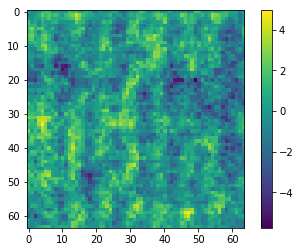

3201 [D loss: 4.667528] [G loss: 7.873217]
3202 [D loss: 2.793823] [G loss: 6.798570]
3203 [D loss: 0.630243] [G loss: 8.997156]
3204 [D loss: -0.567107] [G loss: 9.436983]
3205 [D loss: -0.072998] [G loss: -1.808151]
3206 [D loss: -1.193878] [G loss: -1.757892]
3207 [D loss: -3.203677] [G loss: -3.028231]
3208 [D loss: -4.164008] [G loss: 1.139294]
3209 [D loss: -3.911486] [G loss: -1.716060]
3210 [D loss: -3.528951] [G loss: -0.934610]
3211 [D loss: -3.393651] [G loss: 1.522355]
3212 [D loss: -3.168298] [G loss: 2.180788]
3213 [D loss: -2.933436] [G loss: 1.650917]
3214 [D loss: -2.797744] [G loss: 1.520565]
3215 [D loss: -2.007783] [G loss: -1.220821]
3216 [D loss: -2.702621] [G loss: 0.398344]
3217 [D loss: -3.563438] [G loss: 2.912724]
3218 [D loss: -1.820098] [G loss: -1.966832]
3219 [D loss: -1.917570] [G loss: -6.136858]
3220 [D loss: -2.662303] [G loss: -2.483324]
3221 [D loss: -0.561014] [G loss: -2.929762]
3222 [D loss: -1.202554] [G loss: -7.419825]
3223 [D loss: -0.220105]

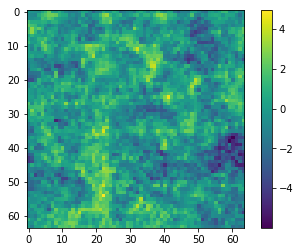

3251 [D loss: 0.086811] [G loss: 7.257229]
3252 [D loss: 0.448206] [G loss: 6.355832]
3253 [D loss: 1.250979] [G loss: 2.932099]
3254 [D loss: 0.453755] [G loss: 2.693758]
3255 [D loss: 0.606175] [G loss: -1.518783]
3256 [D loss: 1.165196] [G loss: 1.690437]
3257 [D loss: 0.393703] [G loss: -2.442443]
3258 [D loss: 0.944973] [G loss: 0.675655]
3259 [D loss: 1.237991] [G loss: 0.958452]
3260 [D loss: 0.229070] [G loss: -0.907080]
3261 [D loss: 0.721796] [G loss: 3.522181]
3262 [D loss: 0.488432] [G loss: 1.434961]
3263 [D loss: 0.305526] [G loss: -4.167414]
3264 [D loss: -1.343181] [G loss: -6.631959]
3265 [D loss: -1.363567] [G loss: -5.734388]
3266 [D loss: -0.527424] [G loss: -5.495903]
3267 [D loss: -0.925180] [G loss: -5.535073]
3268 [D loss: -0.965349] [G loss: -4.081811]
3269 [D loss: -0.441279] [G loss: 0.630696]
3270 [D loss: -0.602155] [G loss: 3.132271]
3271 [D loss: -0.648562] [G loss: 5.258068]
3272 [D loss: -0.876489] [G loss: 8.648041]
3273 [D loss: -0.070416] [G loss: 7.

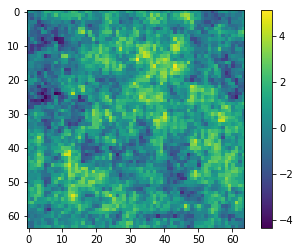

3301 [D loss: -1.275001] [G loss: 3.078830]
3302 [D loss: -0.174845] [G loss: -2.486408]
3303 [D loss: -0.055009] [G loss: -3.583582]
3304 [D loss: 0.467106] [G loss: -3.879338]
3305 [D loss: 0.618585] [G loss: -6.424688]
3306 [D loss: 0.949727] [G loss: 0.549147]
3307 [D loss: -0.034012] [G loss: 3.069495]
3308 [D loss: -0.431534] [G loss: -0.444609]
3309 [D loss: -0.417087] [G loss: 0.256745]
3310 [D loss: -0.444181] [G loss: -0.992412]
3311 [D loss: 0.608938] [G loss: 1.428473]
3312 [D loss: 0.880547] [G loss: 7.249612]
3313 [D loss: 0.439884] [G loss: 9.604826]
3314 [D loss: 1.564735] [G loss: 7.488478]
3315 [D loss: -0.030352] [G loss: 10.595125]
3316 [D loss: 2.086319] [G loss: 10.913729]
3317 [D loss: 2.136900] [G loss: 9.647571]
3318 [D loss: 1.880597] [G loss: 11.710561]
3319 [D loss: 2.083292] [G loss: 10.475876]
3320 [D loss: 2.452810] [G loss: 9.253623]
3321 [D loss: 1.526563] [G loss: 10.104389]
3322 [D loss: 2.594034] [G loss: 6.157324]
3323 [D loss: 0.841684] [G loss: 0.

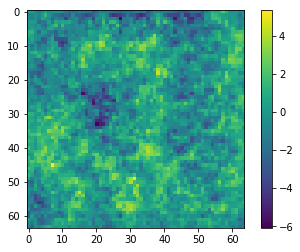

3351 [D loss: 0.403787] [G loss: -1.399004]
3352 [D loss: -0.892964] [G loss: 7.692204]
3353 [D loss: -1.704168] [G loss: 4.050460]
3354 [D loss: -1.351799] [G loss: 6.136309]
3355 [D loss: -0.791976] [G loss: 6.415970]
3356 [D loss: -1.468271] [G loss: 7.461854]
3357 [D loss: -1.019616] [G loss: 9.099699]
3358 [D loss: -0.220905] [G loss: 7.188587]
3359 [D loss: 1.035627] [G loss: 8.714914]
3360 [D loss: 0.311244] [G loss: 8.188031]
3361 [D loss: 0.793777] [G loss: 9.485603]
3362 [D loss: 0.642386] [G loss: 7.255971]
3363 [D loss: 1.025702] [G loss: 10.970996]
3364 [D loss: 0.105368] [G loss: 5.027468]
3365 [D loss: 0.272253] [G loss: 12.200539]
3366 [D loss: -0.549386] [G loss: 1.532535]
3367 [D loss: -0.579991] [G loss: -2.382405]
3368 [D loss: -0.251674] [G loss: 2.768010]
3369 [D loss: -0.112571] [G loss: 0.179490]
3370 [D loss: -0.199946] [G loss: -1.404744]
3371 [D loss: -0.129672] [G loss: 1.525887]
3372 [D loss: 0.284518] [G loss: -0.740425]
3373 [D loss: 0.690306] [G loss: -1

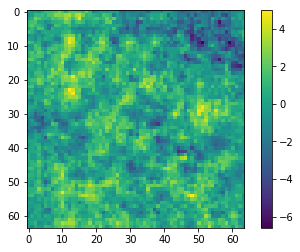

3401 [D loss: 1.138498] [G loss: 8.328691]
3402 [D loss: 1.312405] [G loss: 10.949182]
3403 [D loss: 0.947132] [G loss: 12.120176]
3404 [D loss: 0.732041] [G loss: 11.800240]
3405 [D loss: -0.462716] [G loss: 10.594810]
3406 [D loss: 0.456112] [G loss: -8.954630]
3407 [D loss: 0.171005] [G loss: -7.105243]
3408 [D loss: -0.804330] [G loss: -4.617266]
3409 [D loss: -0.878310] [G loss: -1.590147]
3410 [D loss: -0.558162] [G loss: 0.529510]
3411 [D loss: 0.169541] [G loss: -0.255655]
3412 [D loss: -0.426625] [G loss: 0.354478]
3413 [D loss: 0.002215] [G loss: 1.705601]
3414 [D loss: -0.567158] [G loss: 3.235649]
3415 [D loss: 0.130017] [G loss: 1.491069]
3416 [D loss: 0.186162] [G loss: -1.788070]
3417 [D loss: 0.573549] [G loss: -2.731997]
3418 [D loss: 0.867418] [G loss: -3.357397]
3419 [D loss: 0.244059] [G loss: -4.421469]
3420 [D loss: -0.327818] [G loss: -6.035730]
3421 [D loss: 1.571912] [G loss: -9.029950]
3422 [D loss: 1.496319] [G loss: -7.036991]
3423 [D loss: 1.687255] [G loss

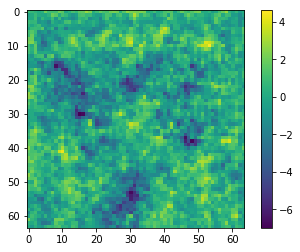

3451 [D loss: 1.123654] [G loss: 11.189230]
3452 [D loss: 1.118618] [G loss: 10.135525]
3453 [D loss: 0.600346] [G loss: 9.871246]
3454 [D loss: 0.686932] [G loss: 10.117749]
3455 [D loss: 1.403208] [G loss: 11.027971]
3456 [D loss: 0.829806] [G loss: 11.953660]
3457 [D loss: 1.583670] [G loss: 11.551139]
3458 [D loss: 0.484815] [G loss: 10.249499]
3459 [D loss: 0.393332] [G loss: 11.952927]
3460 [D loss: 1.314767] [G loss: 11.435381]
3461 [D loss: 0.986984] [G loss: 11.415506]
3462 [D loss: 2.332049] [G loss: 12.719971]
3463 [D loss: 1.839814] [G loss: 11.986570]
3464 [D loss: 0.752499] [G loss: 12.000414]
3465 [D loss: 1.637586] [G loss: 12.264657]
3466 [D loss: 2.679111] [G loss: 12.449448]
3467 [D loss: 2.500659] [G loss: 12.233315]
3468 [D loss: 0.671836] [G loss: 11.894365]
3469 [D loss: -0.528459] [G loss: 8.254536]
3470 [D loss: -2.216756] [G loss: -4.294775]
3471 [D loss: -1.660457] [G loss: -5.721747]
3472 [D loss: -0.691054] [G loss: -5.925835]
3473 [D loss: -2.553270] [G lo

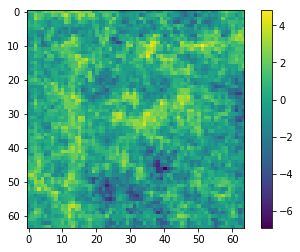

3501 [D loss: 0.228391] [G loss: -3.608758]
3502 [D loss: 0.247853] [G loss: 0.603145]
3503 [D loss: -0.622976] [G loss: -0.811276]
3504 [D loss: -0.358152] [G loss: -4.026638]
3505 [D loss: 0.286694] [G loss: -6.022213]
3506 [D loss: -0.465590] [G loss: -3.976350]
3507 [D loss: -0.869560] [G loss: -0.711501]
3508 [D loss: -1.107595] [G loss: 0.169587]
3509 [D loss: -0.875353] [G loss: -3.820573]
3510 [D loss: -0.298511] [G loss: 2.932452]
3511 [D loss: 0.202404] [G loss: 0.880122]
3512 [D loss: -0.075995] [G loss: -6.302903]
3513 [D loss: 0.501701] [G loss: -7.537232]
3514 [D loss: -0.592874] [G loss: -5.280125]
3515 [D loss: 0.210856] [G loss: -0.533040]
3516 [D loss: -0.258945] [G loss: -4.645491]
3517 [D loss: -0.870987] [G loss: -5.426468]
3518 [D loss: -0.388709] [G loss: -0.180068]
3519 [D loss: -1.038686] [G loss: -0.046521]
3520 [D loss: -0.377337] [G loss: -6.314014]
3521 [D loss: -0.571168] [G loss: -3.797714]
3522 [D loss: -0.651945] [G loss: -0.291040]
3523 [D loss: -0.246

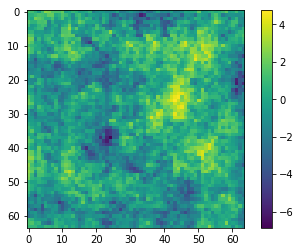

3551 [D loss: 0.347161] [G loss: -9.677374]
3552 [D loss: 0.071112] [G loss: -11.727636]
3553 [D loss: 0.745036] [G loss: -11.107428]
3554 [D loss: -0.691058] [G loss: -9.878485]
3555 [D loss: 0.447542] [G loss: -7.228973]
3556 [D loss: 0.445142] [G loss: -6.312246]
3557 [D loss: 0.813927] [G loss: -4.085892]
3558 [D loss: 0.705623] [G loss: -5.674900]
3559 [D loss: 0.946679] [G loss: -9.509544]
3560 [D loss: 1.031475] [G loss: -8.108660]
3561 [D loss: 1.253169] [G loss: -8.890296]
3562 [D loss: 0.807281] [G loss: -8.798130]
3563 [D loss: 1.646601] [G loss: -11.230434]
3564 [D loss: 0.877563] [G loss: -10.843359]
3565 [D loss: 1.724261] [G loss: -11.099537]
3566 [D loss: 1.425755] [G loss: -11.293733]
3567 [D loss: 0.865081] [G loss: -10.484889]
3568 [D loss: 0.672407] [G loss: -8.409748]
3569 [D loss: 0.919760] [G loss: -9.403454]
3570 [D loss: 0.524409] [G loss: -5.789671]
3571 [D loss: -0.749349] [G loss: 0.767090]
3572 [D loss: -0.019757] [G loss: -10.268748]
3573 [D loss: 0.347614

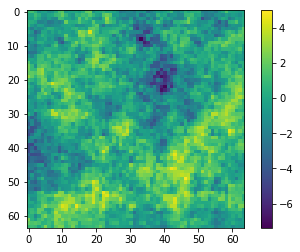

3601 [D loss: 0.278350] [G loss: -0.617718]
3602 [D loss: 0.380444] [G loss: -0.828217]
3603 [D loss: 0.075985] [G loss: 0.991382]
3604 [D loss: -0.991982] [G loss: -1.864007]
3605 [D loss: -1.107472] [G loss: -1.994264]
3606 [D loss: -1.200192] [G loss: -3.567225]
3607 [D loss: 0.662020] [G loss: -3.491082]
3608 [D loss: 0.786832] [G loss: -6.418161]
3609 [D loss: -0.119473] [G loss: -7.203221]
3610 [D loss: 0.177268] [G loss: -8.358410]
3611 [D loss: 0.147528] [G loss: -9.312670]
3612 [D loss: 0.757029] [G loss: -8.611162]
3613 [D loss: 1.061598] [G loss: -9.270582]
3614 [D loss: 0.052252] [G loss: -5.535913]
3615 [D loss: 0.130543] [G loss: 3.843490]
3616 [D loss: 0.009582] [G loss: -6.554965]
3617 [D loss: -0.741269] [G loss: -3.086709]
3618 [D loss: -1.007378] [G loss: -6.869356]
3619 [D loss: -0.769348] [G loss: -5.784170]
3620 [D loss: 0.246672] [G loss: -1.409530]
3621 [D loss: 0.463297] [G loss: -1.608088]
3622 [D loss: -0.268620] [G loss: 0.511956]
3623 [D loss: -0.434788] [G

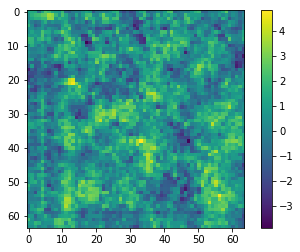

3651 [D loss: 0.212939] [G loss: -9.079834]
3652 [D loss: 0.495571] [G loss: -8.065374]
3653 [D loss: 0.067159] [G loss: -5.784487]
3654 [D loss: -0.827447] [G loss: -7.189009]
3655 [D loss: -0.317531] [G loss: -8.041117]
3656 [D loss: 0.566191] [G loss: -8.316746]
3657 [D loss: 0.301383] [G loss: -5.998295]
3658 [D loss: 0.772185] [G loss: -6.444438]
3659 [D loss: 0.571529] [G loss: -6.132298]
3660 [D loss: 1.169689] [G loss: -3.574301]
3661 [D loss: 0.622649] [G loss: -0.831142]
3662 [D loss: 0.925281] [G loss: 0.409525]
3663 [D loss: 0.400867] [G loss: 1.025640]
3664 [D loss: 0.592603] [G loss: 2.088115]
3665 [D loss: 0.710263] [G loss: 1.162259]
3666 [D loss: 0.639769] [G loss: 2.375022]
3667 [D loss: 0.065407] [G loss: -2.826667]
3668 [D loss: 0.032810] [G loss: -7.599892]
3669 [D loss: -0.908795] [G loss: -9.102362]
3670 [D loss: -0.173828] [G loss: -8.907327]
3671 [D loss: -0.149902] [G loss: -6.761872]
3672 [D loss: 0.877622] [G loss: -5.707719]
3673 [D loss: 0.536903] [G loss:

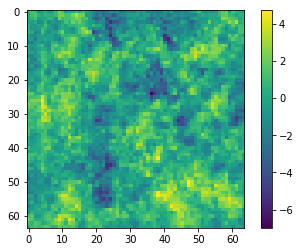

3701 [D loss: 0.134317] [G loss: -6.938275]
3702 [D loss: 0.479581] [G loss: -2.902586]
3703 [D loss: 2.078022] [G loss: 4.659825]
3704 [D loss: 2.495052] [G loss: -5.690835]
3705 [D loss: 0.734090] [G loss: -9.285209]
3706 [D loss: 1.127167] [G loss: -8.034004]
3707 [D loss: 0.616153] [G loss: -3.267104]
3708 [D loss: 0.695188] [G loss: -6.837864]
3709 [D loss: 0.241477] [G loss: -5.103592]
3710 [D loss: -0.209176] [G loss: -6.453856]
3711 [D loss: 0.007808] [G loss: -5.014261]
3712 [D loss: -0.212087] [G loss: -6.699687]
3713 [D loss: 0.355604] [G loss: -7.862679]
3714 [D loss: 0.206548] [G loss: -7.334427]
3715 [D loss: 0.462954] [G loss: -7.785572]
3716 [D loss: 0.550517] [G loss: -7.112833]
3717 [D loss: 1.113581] [G loss: -6.228265]
3718 [D loss: 0.717414] [G loss: -3.798085]
3719 [D loss: -0.612230] [G loss: -0.108785]
3720 [D loss: -0.306167] [G loss: -8.705345]
3721 [D loss: -0.271010] [G loss: -8.958918]
3722 [D loss: -0.917108] [G loss: -8.110621]
3723 [D loss: -0.049826] [G

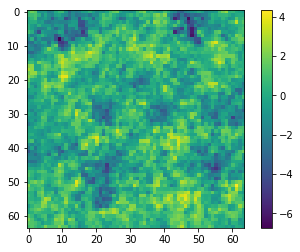

3751 [D loss: -0.539554] [G loss: -6.480801]
3752 [D loss: -0.379487] [G loss: -8.799153]
3753 [D loss: -1.597702] [G loss: -9.627861]
3754 [D loss: -0.677531] [G loss: -10.209620]
3755 [D loss: -0.083073] [G loss: -9.998168]
3756 [D loss: -0.455439] [G loss: -7.591860]
3757 [D loss: 0.274936] [G loss: -5.547364]
3758 [D loss: -0.502868] [G loss: -0.219772]
3759 [D loss: 0.101856] [G loss: -5.170727]
3760 [D loss: -0.464118] [G loss: -0.268824]
3761 [D loss: -0.258480] [G loss: -2.169794]
3762 [D loss: -0.387375] [G loss: -3.425760]
3763 [D loss: -0.178014] [G loss: -1.635736]
3764 [D loss: -0.263844] [G loss: -3.954058]
3765 [D loss: -0.062743] [G loss: -2.127399]
3766 [D loss: -0.207724] [G loss: -0.469258]
3767 [D loss: 0.223271] [G loss: 0.327558]
3768 [D loss: 0.684458] [G loss: -0.493302]
3769 [D loss: 0.361799] [G loss: -3.147957]
3770 [D loss: -0.292077] [G loss: 0.902628]
3771 [D loss: 0.023372] [G loss: -7.934076]
3772 [D loss: -0.334006] [G loss: -5.320187]
3773 [D loss: -0.

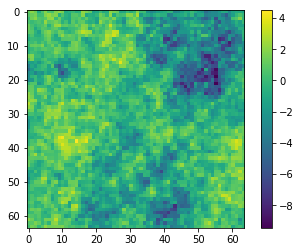

3801 [D loss: -0.537492] [G loss: -4.616080]
3802 [D loss: 0.217397] [G loss: -1.103477]
3803 [D loss: 0.054674] [G loss: -1.760370]
3804 [D loss: 0.501366] [G loss: -4.681997]
3805 [D loss: -0.317978] [G loss: -0.885722]
3806 [D loss: -0.554862] [G loss: -2.529311]
3807 [D loss: -0.173015] [G loss: 0.414847]
3808 [D loss: -1.097399] [G loss: -0.602111]
3809 [D loss: -0.625604] [G loss: 1.541137]
3810 [D loss: 0.132867] [G loss: -3.374993]
3811 [D loss: 0.270985] [G loss: 0.540470]
3812 [D loss: -0.159268] [G loss: 1.980085]
3813 [D loss: 0.418638] [G loss: 0.822121]
3814 [D loss: 0.270905] [G loss: -0.470366]
3815 [D loss: -0.427648] [G loss: -2.514799]
3816 [D loss: -0.282186] [G loss: 0.532036]
3817 [D loss: -0.606467] [G loss: 0.858216]
3818 [D loss: -1.011632] [G loss: 0.863555]
3819 [D loss: 0.319384] [G loss: -1.713701]
3820 [D loss: -0.052942] [G loss: 0.663376]
3821 [D loss: 0.817072] [G loss: 2.067522]
3822 [D loss: -0.448239] [G loss: -3.810617]
3823 [D loss: -0.473238] [G l

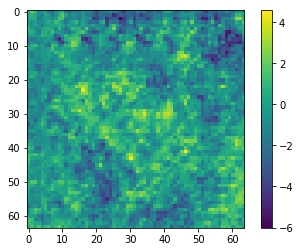

3851 [D loss: -0.025509] [G loss: -8.639339]
3852 [D loss: 0.252585] [G loss: -10.362196]
3853 [D loss: 1.041945] [G loss: -9.565368]
3854 [D loss: 0.928547] [G loss: -11.076207]
3855 [D loss: 0.059591] [G loss: -10.125342]
3856 [D loss: 1.540702] [G loss: -9.968781]
3857 [D loss: 1.297127] [G loss: -9.936703]
3858 [D loss: 0.958933] [G loss: -10.288639]
3859 [D loss: 1.591354] [G loss: -8.234907]
3860 [D loss: 0.938924] [G loss: -10.331871]
3861 [D loss: 0.278503] [G loss: -10.191397]
3862 [D loss: 0.123503] [G loss: -10.610418]
3863 [D loss: 0.154959] [G loss: -12.053675]
3864 [D loss: 0.007672] [G loss: -12.086477]
3865 [D loss: 0.947951] [G loss: -10.766985]
3866 [D loss: 1.247235] [G loss: -9.839608]
3867 [D loss: -0.675182] [G loss: -10.638103]
3868 [D loss: -1.014513] [G loss: -10.246809]
3869 [D loss: -0.574583] [G loss: -11.940451]
3870 [D loss: 0.057622] [G loss: -10.891653]
3871 [D loss: 0.153145] [G loss: -11.991476]
3872 [D loss: 0.313912] [G loss: -10.817625]
3873 [D loss

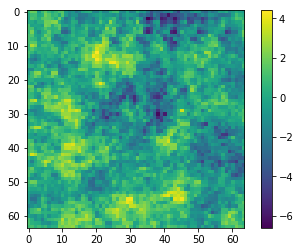

3901 [D loss: -0.193720] [G loss: -1.422450]
3902 [D loss: -0.478602] [G loss: -1.095243]
3903 [D loss: 0.151430] [G loss: -0.130152]
3904 [D loss: -0.114353] [G loss: 0.955930]
3905 [D loss: -0.066195] [G loss: -0.250086]
3906 [D loss: -0.621391] [G loss: -2.617661]
3907 [D loss: -0.112253] [G loss: -5.470085]
3908 [D loss: -0.586574] [G loss: -7.144569]
3909 [D loss: 0.582845] [G loss: -8.806603]
3910 [D loss: 1.105710] [G loss: -9.686122]
3911 [D loss: 1.254298] [G loss: -8.317481]
3912 [D loss: 1.042392] [G loss: -9.543289]
3913 [D loss: 1.211995] [G loss: -5.202147]
3914 [D loss: 1.780380] [G loss: 0.663757]
3915 [D loss: 1.400403] [G loss: 2.796171]
3916 [D loss: 1.041681] [G loss: 2.174496]
3917 [D loss: 0.359786] [G loss: -12.674601]
3918 [D loss: 0.902298] [G loss: -11.341339]
3919 [D loss: 0.676106] [G loss: -10.528906]
3920 [D loss: -0.345324] [G loss: -10.743921]
3921 [D loss: 0.341086] [G loss: -9.480760]
3922 [D loss: -0.073348] [G loss: -10.383577]
3923 [D loss: -0.21042

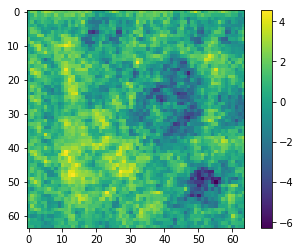

3951 [D loss: 0.605393] [G loss: -9.895546]
3952 [D loss: 1.323412] [G loss: -7.350667]
3953 [D loss: 0.712947] [G loss: -0.234456]
3954 [D loss: 0.611091] [G loss: -4.197923]
3955 [D loss: 0.044659] [G loss: -7.948585]
3956 [D loss: -0.042500] [G loss: -10.976144]
3957 [D loss: -0.257209] [G loss: -11.488558]
3958 [D loss: -0.226702] [G loss: -11.872709]
3959 [D loss: 1.057190] [G loss: -10.682690]
3960 [D loss: 0.204794] [G loss: -10.940287]
3961 [D loss: -0.183138] [G loss: -12.013256]
3962 [D loss: 0.309434] [G loss: -10.481928]
3963 [D loss: 0.218597] [G loss: -11.256077]
3964 [D loss: 0.878205] [G loss: -9.960646]
3965 [D loss: 0.931304] [G loss: -13.895100]
3966 [D loss: 1.358494] [G loss: -11.401415]
3967 [D loss: 0.992874] [G loss: -10.667412]
3968 [D loss: 1.430036] [G loss: -10.186638]
3969 [D loss: 1.025593] [G loss: -10.889537]
3970 [D loss: 2.019828] [G loss: -11.346017]
3971 [D loss: 1.896647] [G loss: -9.800214]
3972 [D loss: -1.161295] [G loss: -9.994414]
3973 [D loss:

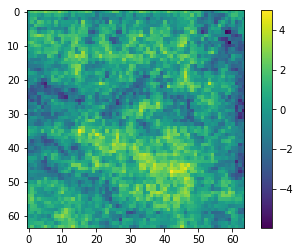

4001 [D loss: 1.001375] [G loss: -10.305716]
4002 [D loss: 0.653089] [G loss: -9.706931]
4003 [D loss: -0.172607] [G loss: -10.652927]
4004 [D loss: 0.931545] [G loss: -8.657457]
4005 [D loss: 0.020552] [G loss: -9.421979]
4006 [D loss: -0.481880] [G loss: -10.520953]
4007 [D loss: 1.270195] [G loss: -11.411278]
4008 [D loss: 1.476684] [G loss: -9.896580]
4009 [D loss: 0.670246] [G loss: -9.026115]
4010 [D loss: 0.410705] [G loss: -10.200682]
4011 [D loss: 0.672799] [G loss: -10.085514]
4012 [D loss: 0.511261] [G loss: -9.960947]
4013 [D loss: 1.833061] [G loss: -9.376607]
4014 [D loss: 1.105329] [G loss: -8.769510]
4015 [D loss: 0.181957] [G loss: -5.651807]
4016 [D loss: -0.242255] [G loss: -9.043064]
4017 [D loss: 0.208835] [G loss: -8.894934]
4018 [D loss: 0.206884] [G loss: -8.094160]
4019 [D loss: 0.045139] [G loss: -7.620067]
4020 [D loss: 0.622490] [G loss: -8.807493]
4021 [D loss: -0.138011] [G loss: -6.512503]
4022 [D loss: -0.447168] [G loss: -6.524732]
4023 [D loss: -0.1978

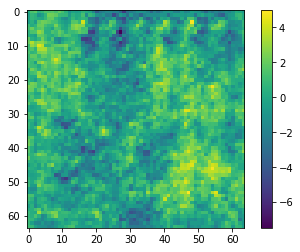

4051 [D loss: 1.549837] [G loss: -9.890087]
4052 [D loss: 2.723085] [G loss: -9.798494]
4053 [D loss: 12.319951] [G loss: -8.844936]
4054 [D loss: 1.919348] [G loss: -11.064558]
4055 [D loss: 1.075923] [G loss: -8.478988]
4056 [D loss: 0.672676] [G loss: -6.926015]
4057 [D loss: 0.885615] [G loss: -7.368877]
4058 [D loss: 0.832759] [G loss: -8.342973]
4059 [D loss: 0.835626] [G loss: -10.509003]
4060 [D loss: 1.096307] [G loss: -9.337872]
4061 [D loss: 1.283230] [G loss: -8.461616]
4062 [D loss: 1.630743] [G loss: -8.705009]
4063 [D loss: 1.286990] [G loss: -8.365591]
4064 [D loss: 1.000660] [G loss: -6.508756]
4065 [D loss: 1.411487] [G loss: -5.262494]
4066 [D loss: 1.586049] [G loss: 1.797519]
4067 [D loss: 1.203383] [G loss: 6.248222]
4068 [D loss: 1.271282] [G loss: -3.190536]
4069 [D loss: 0.963353] [G loss: -2.431542]
4070 [D loss: 1.225091] [G loss: -3.270336]
4071 [D loss: 0.969322] [G loss: -3.538687]
4072 [D loss: 1.097256] [G loss: -4.866529]
4073 [D loss: 0.086127] [G loss

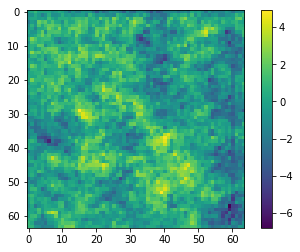

4101 [D loss: -0.429194] [G loss: -3.542886]
4102 [D loss: 0.228836] [G loss: -4.130681]
4103 [D loss: -0.033445] [G loss: -2.421759]
4104 [D loss: 0.449378] [G loss: -5.781116]
4105 [D loss: -0.112756] [G loss: -2.133624]
4106 [D loss: 0.334261] [G loss: -5.672260]
4107 [D loss: -0.507931] [G loss: -6.164997]
4108 [D loss: -0.154313] [G loss: -4.292407]
4109 [D loss: 0.275807] [G loss: 0.122050]
4110 [D loss: 0.513416] [G loss: -7.054748]
4111 [D loss: 0.142300] [G loss: -5.130579]
4112 [D loss: 0.168848] [G loss: -9.780386]
4113 [D loss: 0.682149] [G loss: -9.456753]
4114 [D loss: 0.756408] [G loss: -7.335332]
4115 [D loss: 1.357430] [G loss: -7.712039]
4116 [D loss: 1.008252] [G loss: -6.128461]
4117 [D loss: 0.732812] [G loss: -8.478861]
4118 [D loss: 1.223817] [G loss: -9.464348]
4119 [D loss: 0.737374] [G loss: -5.414247]
4120 [D loss: 0.503348] [G loss: -5.608953]
4121 [D loss: -0.178494] [G loss: -4.279187]
4122 [D loss: -0.907117] [G loss: -6.292153]
4123 [D loss: -1.053010] [

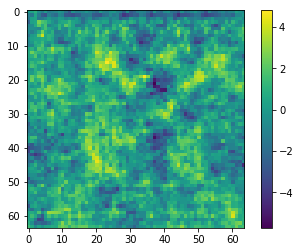

4151 [D loss: 0.237567] [G loss: 6.997331]
4152 [D loss: -0.350519] [G loss: 3.302188]
4153 [D loss: -0.454642] [G loss: 2.213047]
4154 [D loss: 0.308681] [G loss: -0.694907]
4155 [D loss: -0.069552] [G loss: -1.583169]
4156 [D loss: -0.165303] [G loss: -6.185575]
4157 [D loss: 0.539438] [G loss: -8.167951]
4158 [D loss: 1.086402] [G loss: -8.267174]
4159 [D loss: 1.717660] [G loss: -5.863249]
4160 [D loss: 2.408012] [G loss: -3.092467]
4161 [D loss: 3.164948] [G loss: 6.841990]
4162 [D loss: 1.308747] [G loss: 7.212565]
4163 [D loss: 1.986518] [G loss: 7.166221]
4164 [D loss: 1.966107] [G loss: 5.087610]
4165 [D loss: -0.747580] [G loss: -8.203684]
4166 [D loss: -1.423315] [G loss: -3.344490]
4167 [D loss: -3.892154] [G loss: 2.487189]
4168 [D loss: -2.639728] [G loss: 0.286339]
4169 [D loss: -2.082036] [G loss: -1.129406]
4170 [D loss: -2.603147] [G loss: 0.935891]
4171 [D loss: -1.561851] [G loss: 4.798949]
4172 [D loss: -0.361239] [G loss: -4.468949]
4173 [D loss: 0.513337] [G loss

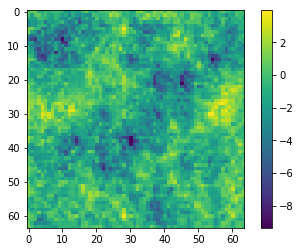

4201 [D loss: 0.921517] [G loss: 4.169489]
4202 [D loss: 0.303227] [G loss: 5.569530]
4203 [D loss: 0.546479] [G loss: 5.438853]
4204 [D loss: -0.005803] [G loss: 2.924071]
4205 [D loss: -0.233375] [G loss: 1.534849]
4206 [D loss: -0.145577] [G loss: 3.769395]
4207 [D loss: -0.672388] [G loss: -3.018445]
4208 [D loss: -0.096061] [G loss: -3.388212]
4209 [D loss: -0.033267] [G loss: -6.746113]
4210 [D loss: 0.263758] [G loss: -3.610238]
4211 [D loss: 1.401202] [G loss: -5.383345]
4212 [D loss: 0.912140] [G loss: -3.664435]
4213 [D loss: 1.712890] [G loss: -2.824971]
4214 [D loss: 1.597176] [G loss: -0.016979]
4215 [D loss: 1.434809] [G loss: 5.172250]
4216 [D loss: 1.159334] [G loss: 7.313011]
4217 [D loss: 1.219480] [G loss: 6.491227]
4218 [D loss: 1.244395] [G loss: 6.705928]
4219 [D loss: 1.671304] [G loss: 7.483635]
4220 [D loss: 1.144883] [G loss: 7.024874]
4221 [D loss: 1.334599] [G loss: 5.043504]
4222 [D loss: 0.002225] [G loss: 5.965846]
4223 [D loss: -2.019057] [G loss: 7.9908

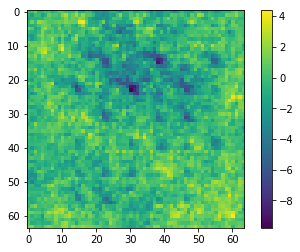

4251 [D loss: -5.281726] [G loss: -4.932422]
4252 [D loss: -4.037245] [G loss: -1.848977]
4253 [D loss: -3.469954] [G loss: -5.990985]
4254 [D loss: -2.881109] [G loss: -4.040170]
4255 [D loss: -2.899673] [G loss: -6.639737]
4256 [D loss: -2.285261] [G loss: -7.444805]
4257 [D loss: -1.507451] [G loss: -8.853029]
4258 [D loss: 0.253955] [G loss: -9.918156]
4259 [D loss: 0.210802] [G loss: -6.975858]
4260 [D loss: 1.057552] [G loss: -9.540977]
4261 [D loss: 1.040564] [G loss: -9.263218]
4262 [D loss: 1.797734] [G loss: -8.712622]
4263 [D loss: 1.452524] [G loss: -10.007999]
4264 [D loss: 1.850664] [G loss: -6.167222]
4265 [D loss: 1.525596] [G loss: -1.427352]
4266 [D loss: -0.786498] [G loss: -2.208565]
4267 [D loss: -1.402729] [G loss: -6.869826]
4268 [D loss: -0.137679] [G loss: -6.833960]
4269 [D loss: 0.180086] [G loss: -12.857805]
4270 [D loss: -0.344350] [G loss: -10.683220]
4271 [D loss: -1.333271] [G loss: -9.907785]
4272 [D loss: 0.109244] [G loss: -10.968463]
4273 [D loss: 0.

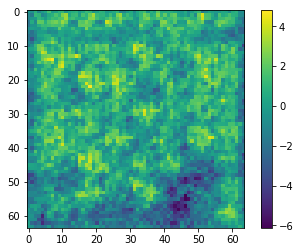

4301 [D loss: 1.921224] [G loss: -10.767541]
4302 [D loss: 1.204472] [G loss: -9.034224]
4303 [D loss: 1.582655] [G loss: -6.706569]
4304 [D loss: -1.745025] [G loss: -5.952269]
4305 [D loss: -3.015652] [G loss: -2.624970]
4306 [D loss: -2.908063] [G loss: -4.583510]
4307 [D loss: -1.504710] [G loss: -6.925253]
4308 [D loss: -1.186507] [G loss: -7.325574]
4309 [D loss: -1.050195] [G loss: -8.779328]
4310 [D loss: -0.259049] [G loss: -11.517733]
4311 [D loss: 0.173671] [G loss: -11.084929]
4312 [D loss: -0.208084] [G loss: -10.358912]
4313 [D loss: 0.925311] [G loss: -9.940497]
4314 [D loss: 0.283523] [G loss: -11.240907]
4315 [D loss: 0.929597] [G loss: -7.053269]
4316 [D loss: 0.950441] [G loss: -8.673719]
4317 [D loss: -0.069314] [G loss: -7.635634]
4318 [D loss: 0.988205] [G loss: -9.229406]
4319 [D loss: 0.120124] [G loss: -8.861325]
4320 [D loss: 0.057029] [G loss: -7.964243]
4321 [D loss: 0.803654] [G loss: -9.358638]
4322 [D loss: 0.960730] [G loss: -8.859110]
4323 [D loss: 0.93

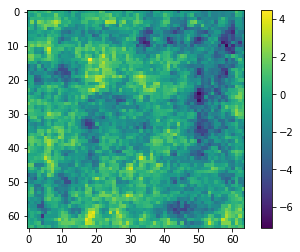

4351 [D loss: -0.875203] [G loss: -4.197891]
4352 [D loss: -2.206069] [G loss: -4.669188]
4353 [D loss: -1.002755] [G loss: -9.209798]
4354 [D loss: -0.097653] [G loss: -10.465770]
4355 [D loss: 0.550250] [G loss: -10.906745]
4356 [D loss: -0.371638] [G loss: -10.968518]
4357 [D loss: 0.388088] [G loss: -12.147400]
4358 [D loss: 0.832445] [G loss: -10.213224]
4359 [D loss: 0.345609] [G loss: -11.007018]
4360 [D loss: 1.357840] [G loss: -4.430290]
4361 [D loss: 1.340802] [G loss: 3.523352]
4362 [D loss: -1.603929] [G loss: -5.610524]
4363 [D loss: -2.137547] [G loss: -9.283333]
4364 [D loss: -1.485947] [G loss: -11.427505]
4365 [D loss: -1.048501] [G loss: -11.031565]
4366 [D loss: -0.011269] [G loss: -11.114492]
4367 [D loss: 0.510725] [G loss: -11.746681]
4368 [D loss: -0.204672] [G loss: -12.064132]
4369 [D loss: -0.139235] [G loss: -12.791048]
4370 [D loss: 1.000551] [G loss: -12.438980]
4371 [D loss: 0.636203] [G loss: -13.019201]
4372 [D loss: 0.319576] [G loss: -11.814193]
4373 [

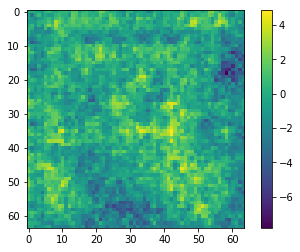

4401 [D loss: 0.509974] [G loss: -12.369740]
4402 [D loss: 1.841535] [G loss: -13.807028]
4403 [D loss: 1.885528] [G loss: -13.488668]
4404 [D loss: 2.280655] [G loss: -13.497454]
4405 [D loss: 3.813118] [G loss: -12.628490]
4406 [D loss: 3.066722] [G loss: -12.651827]
4407 [D loss: 3.230329] [G loss: -7.189616]
4408 [D loss: 1.732011] [G loss: 6.107972]
4409 [D loss: -3.031381] [G loss: -1.253030]
4410 [D loss: -3.063488] [G loss: -8.737465]
4411 [D loss: -2.707764] [G loss: -10.729386]
4412 [D loss: -1.736877] [G loss: -10.278793]
4413 [D loss: -1.157464] [G loss: -10.567575]
4414 [D loss: -0.930812] [G loss: -11.884268]
4415 [D loss: -0.558407] [G loss: -11.316992]
4416 [D loss: 0.225075] [G loss: -10.978361]
4417 [D loss: 0.857206] [G loss: -10.877954]
4418 [D loss: 0.809479] [G loss: -8.237310]
4419 [D loss: 0.069571] [G loss: -5.210871]
4420 [D loss: 0.204612] [G loss: -1.328958]
4421 [D loss: -1.229712] [G loss: -2.490415]
4422 [D loss: -1.373312] [G loss: -7.092742]
4423 [D los

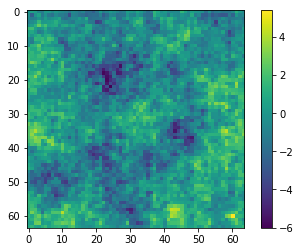

4451 [D loss: 2.317859] [G loss: 13.506222]
4452 [D loss: 2.352837] [G loss: 13.401741]
4453 [D loss: 2.492464] [G loss: 13.508621]
4454 [D loss: 2.937948] [G loss: 11.609903]
4455 [D loss: 2.498498] [G loss: 11.634752]
4456 [D loss: 1.773814] [G loss: 11.685486]
4457 [D loss: 1.043923] [G loss: 9.996831]
4458 [D loss: 0.962804] [G loss: 12.624651]
4459 [D loss: 0.616094] [G loss: 12.403554]
4460 [D loss: 1.113926] [G loss: 12.699882]
4461 [D loss: 0.700687] [G loss: 12.934305]
4462 [D loss: 1.474561] [G loss: 12.855345]
4463 [D loss: 1.494142] [G loss: 12.265304]
4464 [D loss: 1.632396] [G loss: 12.367546]
4465 [D loss: 2.101545] [G loss: 12.402693]
4466 [D loss: 0.346987] [G loss: 11.451159]
4467 [D loss: -0.360308] [G loss: 12.734085]
4468 [D loss: 1.106740] [G loss: 13.279936]
4469 [D loss: 0.064663] [G loss: 11.108409]
4470 [D loss: 1.133695] [G loss: 13.426523]
4471 [D loss: 0.401212] [G loss: 11.857330]
4472 [D loss: -0.646943] [G loss: 12.093475]
4473 [D loss: 0.110010] [G loss

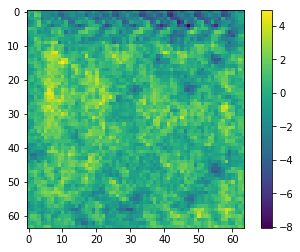

4501 [D loss: -1.480574] [G loss: 7.250733]
4502 [D loss: -1.387028] [G loss: 6.589951]
4503 [D loss: -0.447891] [G loss: 8.156603]
4504 [D loss: -0.713480] [G loss: 7.298900]
4505 [D loss: -1.111059] [G loss: 5.722869]
4506 [D loss: -0.841302] [G loss: 4.431234]
4507 [D loss: -0.612344] [G loss: 5.067229]
4508 [D loss: -0.518929] [G loss: 6.141507]
4509 [D loss: -1.802306] [G loss: 7.214178]
4510 [D loss: -0.573582] [G loss: 6.220969]
4511 [D loss: -0.472273] [G loss: 5.687704]
4512 [D loss: -2.075718] [G loss: 4.304726]
4513 [D loss: 0.036160] [G loss: 6.249025]
4514 [D loss: 1.005834] [G loss: 8.483521]
4515 [D loss: 0.552469] [G loss: 12.352940]
4516 [D loss: 1.684108] [G loss: 11.343775]
4517 [D loss: 1.081226] [G loss: 11.292662]
4518 [D loss: 1.643707] [G loss: 12.151535]
4519 [D loss: 0.305616] [G loss: 12.125912]
4520 [D loss: 0.378211] [G loss: 12.124898]
4521 [D loss: 1.297050] [G loss: 11.784777]
4522 [D loss: 0.104789] [G loss: 10.444542]
4523 [D loss: -0.545843] [G loss: 

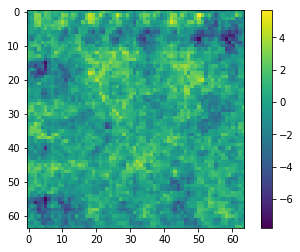

4551 [D loss: 0.179226] [G loss: -8.632820]
4552 [D loss: -1.252424] [G loss: -8.221024]
4553 [D loss: -0.506027] [G loss: -8.216650]
4554 [D loss: -0.936301] [G loss: -7.874064]
4555 [D loss: -0.880322] [G loss: -8.114668]
4556 [D loss: 0.068739] [G loss: -2.740133]
4557 [D loss: -1.067304] [G loss: -1.763451]
4558 [D loss: -0.306386] [G loss: -1.212752]
4559 [D loss: -0.579294] [G loss: -2.903095]
4560 [D loss: -1.232836] [G loss: -3.591896]
4561 [D loss: -0.759302] [G loss: -7.947514]
4562 [D loss: -1.271289] [G loss: -10.694262]
4563 [D loss: -1.708569] [G loss: -7.079704]
4564 [D loss: 0.103344] [G loss: -6.303042]
4565 [D loss: 0.613952] [G loss: -6.219722]
4566 [D loss: 1.578370] [G loss: -8.773586]
4567 [D loss: 0.069835] [G loss: -7.928955]
4568 [D loss: 1.334543] [G loss: -11.247349]
4569 [D loss: 0.648002] [G loss: -12.880794]
4570 [D loss: 0.896190] [G loss: -11.381071]
4571 [D loss: -0.547340] [G loss: -9.351270]
4572 [D loss: -1.475901] [G loss: -7.018240]
4573 [D loss: -

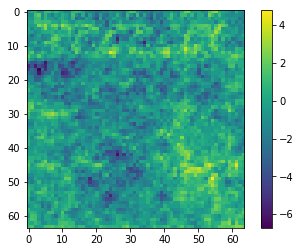

4601 [D loss: 1.675190] [G loss: -13.975101]
4602 [D loss: 2.419671] [G loss: -15.753813]
4603 [D loss: 2.904238] [G loss: -16.324034]
4604 [D loss: 1.988311] [G loss: -14.773098]
4605 [D loss: 1.968282] [G loss: -15.679856]
4606 [D loss: 3.009546] [G loss: -14.373304]
4607 [D loss: 1.874792] [G loss: -15.283322]
4608 [D loss: 1.020704] [G loss: -14.029577]
4609 [D loss: 1.158787] [G loss: -11.224493]
4610 [D loss: -1.443297] [G loss: -10.018740]
4611 [D loss: 0.141479] [G loss: -10.088197]
4612 [D loss: -0.386828] [G loss: -11.028350]
4613 [D loss: -0.823465] [G loss: -7.327800]
4614 [D loss: -0.201750] [G loss: -7.971216]
4615 [D loss: -0.087901] [G loss: -9.075060]
4616 [D loss: 0.020786] [G loss: -10.155600]
4617 [D loss: 0.039645] [G loss: -10.154421]
4618 [D loss: -0.209875] [G loss: -10.450968]
4619 [D loss: 0.919747] [G loss: -12.343604]
4620 [D loss: 0.510090] [G loss: -13.364033]
4621 [D loss: 1.288909] [G loss: -11.483469]
4622 [D loss: 2.329663] [G loss: -13.041363]
4623 [D

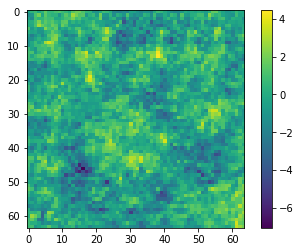

4651 [D loss: 2.308041] [G loss: 12.198387]
4652 [D loss: 1.124618] [G loss: 8.405851]
4653 [D loss: 0.352956] [G loss: 8.808472]
4654 [D loss: 1.613369] [G loss: 8.592172]
4655 [D loss: 0.565657] [G loss: 11.449560]
4656 [D loss: 1.834551] [G loss: 12.976905]
4657 [D loss: 4.856855] [G loss: 14.010692]
4658 [D loss: 4.175882] [G loss: 11.306582]
4659 [D loss: 2.393602] [G loss: 11.643995]
4660 [D loss: 2.479156] [G loss: 10.469120]
4661 [D loss: 3.838891] [G loss: 9.806244]
4662 [D loss: 3.611827] [G loss: 8.118831]
4663 [D loss: 3.117948] [G loss: 7.879321]
4664 [D loss: 1.898642] [G loss: 2.605270]
4665 [D loss: -1.075051] [G loss: -1.752748]
4666 [D loss: -1.221979] [G loss: -0.643295]
4667 [D loss: -1.169279] [G loss: -3.301789]
4668 [D loss: -0.348081] [G loss: -2.306337]
4669 [D loss: 0.936238] [G loss: -3.245407]
4670 [D loss: 0.073646] [G loss: -0.833961]
4671 [D loss: 0.569135] [G loss: 3.213942]
4672 [D loss: -1.164796] [G loss: 0.998542]
4673 [D loss: -3.562484] [G loss: -0

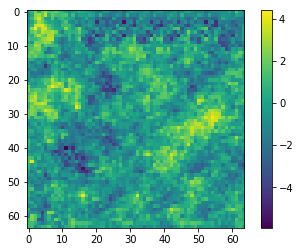

4701 [D loss: 0.544605] [G loss: 6.076099]
4702 [D loss: 0.193977] [G loss: 1.505023]
4703 [D loss: 0.893539] [G loss: 4.850409]
4704 [D loss: 0.686284] [G loss: 2.773231]
4705 [D loss: 0.867846] [G loss: 6.747130]
4706 [D loss: -0.267832] [G loss: 5.131523]
4707 [D loss: -1.583967] [G loss: 1.904175]
4708 [D loss: -0.407309] [G loss: 7.862844]
4709 [D loss: 0.133402] [G loss: 7.328603]
4710 [D loss: -0.295944] [G loss: 5.484847]
4711 [D loss: 0.327222] [G loss: 2.371216]
4712 [D loss: -0.410144] [G loss: -4.448640]
4713 [D loss: -0.706976] [G loss: -2.514846]
4714 [D loss: -1.483214] [G loss: -4.000486]
4715 [D loss: -0.646283] [G loss: -2.365294]
4716 [D loss: -0.660925] [G loss: 2.097918]
4717 [D loss: 0.323146] [G loss: -1.214942]
4718 [D loss: -0.005899] [G loss: -0.305923]
4719 [D loss: -0.540034] [G loss: 3.948375]
4720 [D loss: 0.766336] [G loss: 3.855912]
4721 [D loss: 0.367752] [G loss: 7.033532]
4722 [D loss: 0.954481] [G loss: 6.791249]
4723 [D loss: 1.273960] [G loss: 7.72

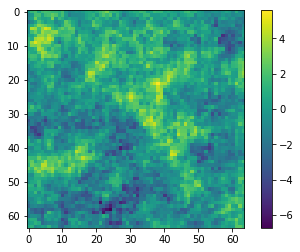

4751 [D loss: -1.874893] [G loss: -3.835788]
4752 [D loss: -1.193270] [G loss: -2.795051]
4753 [D loss: -2.203021] [G loss: -1.160221]
4754 [D loss: -0.532561] [G loss: 2.130122]
4755 [D loss: 0.248859] [G loss: -1.381778]
4756 [D loss: -1.399375] [G loss: -3.802181]
4757 [D loss: 1.000867] [G loss: -6.461516]
4758 [D loss: -0.273440] [G loss: -11.331476]
4759 [D loss: 1.189609] [G loss: -11.719295]
4760 [D loss: 1.899700] [G loss: -10.729073]
4761 [D loss: 1.248874] [G loss: -11.503450]
4762 [D loss: 2.203709] [G loss: -12.742601]
4763 [D loss: 3.005915] [G loss: -11.306166]
4764 [D loss: 2.253035] [G loss: -10.547550]
4765 [D loss: 2.004313] [G loss: -12.266336]
4766 [D loss: 1.390480] [G loss: -11.908201]
4767 [D loss: 1.609678] [G loss: -6.506366]
4768 [D loss: 0.742296] [G loss: -2.614002]
4769 [D loss: 0.200544] [G loss: -2.414011]
4770 [D loss: -1.903033] [G loss: 0.074865]
4771 [D loss: -0.484373] [G loss: -1.309447]
4772 [D loss: -0.965746] [G loss: -1.455655]
4773 [D loss: 0.

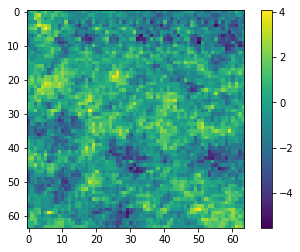

4801 [D loss: -1.752584] [G loss: -6.362686]
4802 [D loss: -0.394677] [G loss: -3.820092]
4803 [D loss: 0.656190] [G loss: -7.585610]
4804 [D loss: 0.850655] [G loss: -10.169607]
4805 [D loss: 0.709249] [G loss: -8.624048]
4806 [D loss: 3.847480] [G loss: -13.612722]
4807 [D loss: 3.263426] [G loss: -13.971463]
4808 [D loss: 1.743758] [G loss: -13.976416]
4809 [D loss: 0.377046] [G loss: -2.278593]
4810 [D loss: -2.397213] [G loss: 4.073908]
4811 [D loss: -2.329365] [G loss: -0.480761]
4812 [D loss: -2.686255] [G loss: -3.807761]
4813 [D loss: -1.544123] [G loss: -2.564627]
4814 [D loss: -0.885798] [G loss: -1.396088]
4815 [D loss: 0.076877] [G loss: -7.973207]
4816 [D loss: 0.330743] [G loss: -6.733214]
4817 [D loss: 1.374919] [G loss: -6.005448]
4818 [D loss: -0.342145] [G loss: -9.295656]
4819 [D loss: 0.492122] [G loss: -13.149868]
4820 [D loss: 0.353966] [G loss: -8.429631]
4821 [D loss: -1.415535] [G loss: 0.161116]
4822 [D loss: -1.236106] [G loss: -3.580667]
4823 [D loss: -1.51

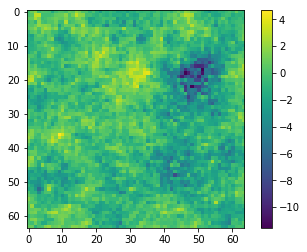

4851 [D loss: 1.176378] [G loss: -10.405420]
4852 [D loss: 0.278568] [G loss: -11.295269]
4853 [D loss: 0.793972] [G loss: -14.803541]
4854 [D loss: 0.629447] [G loss: -12.402702]
4855 [D loss: 1.113017] [G loss: -12.053921]
4856 [D loss: 0.841646] [G loss: -12.225270]
4857 [D loss: 0.195447] [G loss: -14.222753]
4858 [D loss: 2.138277] [G loss: -13.343992]
4859 [D loss: 0.960112] [G loss: -13.911477]
4860 [D loss: 0.543035] [G loss: -13.939478]
4861 [D loss: 1.624914] [G loss: -15.334105]
4862 [D loss: 1.254079] [G loss: -14.401298]
4863 [D loss: 1.628521] [G loss: -13.873911]
4864 [D loss: 0.924016] [G loss: -12.773511]
4865 [D loss: 2.395366] [G loss: -13.275888]
4866 [D loss: 0.172954] [G loss: -7.492987]
4867 [D loss: -0.149769] [G loss: -11.738817]
4868 [D loss: -0.501459] [G loss: -11.714804]
4869 [D loss: 0.780929] [G loss: -10.834165]
4870 [D loss: 1.349619] [G loss: -10.374410]
4871 [D loss: 0.808967] [G loss: -11.557089]
4872 [D loss: 0.071361] [G loss: -7.972349]
4873 [D lo

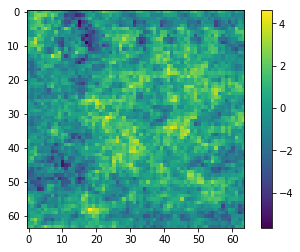

4901 [D loss: -0.248778] [G loss: -3.258175]
4902 [D loss: -0.371156] [G loss: -6.207707]
4903 [D loss: -0.909971] [G loss: -5.021951]
4904 [D loss: -0.897588] [G loss: -7.621086]
4905 [D loss: -0.327234] [G loss: -3.584514]
4906 [D loss: -0.054701] [G loss: -2.795835]
4907 [D loss: 0.785063] [G loss: -3.592625]
4908 [D loss: -0.736706] [G loss: -6.519138]
4909 [D loss: -1.003536] [G loss: -2.478115]
4910 [D loss: -0.118184] [G loss: -6.864333]
4911 [D loss: 0.251608] [G loss: -1.125479]
4912 [D loss: -0.275290] [G loss: -5.363311]
4913 [D loss: -0.062627] [G loss: -8.241501]
4914 [D loss: -1.099471] [G loss: -7.520411]
4915 [D loss: -0.090240] [G loss: -8.738949]
4916 [D loss: -0.247369] [G loss: -9.013695]
4917 [D loss: -0.422783] [G loss: -2.301011]
4918 [D loss: -0.539713] [G loss: -3.730131]
4919 [D loss: -0.879243] [G loss: -7.652141]
4920 [D loss: -0.757462] [G loss: -4.547729]
4921 [D loss: -1.008582] [G loss: -8.980940]
4922 [D loss: 0.297463] [G loss: -1.806452]
4923 [D loss:

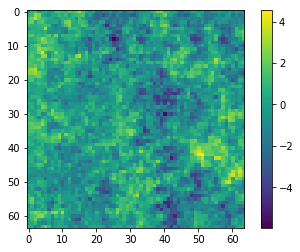

4951 [D loss: 1.088012] [G loss: -5.367531]
4952 [D loss: 1.417943] [G loss: -8.802577]
4953 [D loss: 1.317123] [G loss: -3.374039]
4954 [D loss: 0.305310] [G loss: -3.370855]
4955 [D loss: 0.456914] [G loss: 0.255788]
4956 [D loss: -1.266583] [G loss: 4.081571]
4957 [D loss: 0.143701] [G loss: 2.596372]
4958 [D loss: -1.241008] [G loss: 4.739950]
4959 [D loss: 0.265570] [G loss: 0.694311]
4960 [D loss: -0.166715] [G loss: -3.755777]
4961 [D loss: 0.378896] [G loss: -5.711962]
4962 [D loss: 0.267242] [G loss: -5.557170]
4963 [D loss: 0.054826] [G loss: -10.820224]
4964 [D loss: 0.700680] [G loss: -6.197578]
4965 [D loss: -0.411171] [G loss: -4.164760]
4966 [D loss: 0.248092] [G loss: -6.313425]
4967 [D loss: 1.377317] [G loss: -8.262753]
4968 [D loss: 0.596667] [G loss: -10.069969]
4969 [D loss: 1.068761] [G loss: -11.386559]
4970 [D loss: 1.264529] [G loss: -10.962435]
4971 [D loss: 1.516811] [G loss: -14.294266]
4972 [D loss: 1.424975] [G loss: -14.335845]
4973 [D loss: 1.741872] [G 

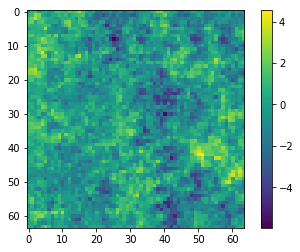

In [20]:
# Train the darn thing
batch_size = 32
epochs = 5000
n_critic = 5

# Adversarial ground truths
valid = -np.ones((batch_size, 1))
fake =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty

d_hist = []
g_hist = []
for epoch in range(epochs):
    
    for _ in range(n_critic):

        # ---------------------
        #  Train Discriminator
        # ---------------------
    
        # Generate some true images
        imgs = np.zeros((batch_size, img_rows, img_cols))
        for i in range(batch_size):
            imgs[i] = grf_2d(1.0, alpha=-2.0, normalize=True)
            #imgs[i] = gspot(5.0, 0.05)
        imgs =imgs.reshape((batch_size, img_rows, img_cols, 1))

        # Sample generator input
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        # Train the critic
        d_loss = critic_model.train_on_batch([imgs, noise],
                                             [valid, fake, dummy])

    # ---------------------
    #  Train Generator
    # ---------------------

    g_loss = generator_model.train_on_batch(noise, valid)

    # Plot the progress
    print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
    
    d_hist.append(d_loss[0])
    g_hist.append(g_loss)
    
    if epoch % 50 == 0:
        test_img = generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64)
        clf()
        imshow(test_img)
        colorbar()
        display.display(gcf())
        
    

In [56]:
# Train the darn thing
batch_size = 32
epochs = 5000

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

ngen_update = 1

d_hist = []
g_hist = []

for epoch in range(epochs):
    
    #if (epoch//train_chunk) //2*2 != (epoch//train_chunk):
    if True:
        
   #     print("Training discriminator...")

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Generate some true images
        imgs = np.zeros((batch_size, img_rows, img_cols))
        for i in range(batch_size):
            imgs[i] = grf_2d(1.0, alpha=-2.0, normalize=True)
            #imgs[i] = gspot(5.0, 0.05)
        imgs =imgs.reshape((batch_size, img_rows, img_cols, 1))

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        #discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        
    #    print ("%d [D loss: %f, acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1]))

    # ---------------------
    #  Train Generator
    # ---------------------
    
    #if (epoch//train_chunk) //2*2 == (epoch//train_chunk):
    for i in range(ngen_update):
        
        #print("Training generator...")

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        #discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, valid)
        
    #    print ("%d [G loss: %f]" % (epoch, g_loss))

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    d_hist.append(d_loss[0])
    g_hist.append(g_loss)

    # If at save interval => save generated image samples
    #if epoch % sample_interval == 0:
    #    self.sample_images(epoch)
    
    if epoch % 20 == 0:
        test_img = generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64)
        clf()
        imshow(test_img)
        colorbar()
        display.display(gcf())


ValueError: Tensor("training/Adam/Const:0", shape=(), dtype=float32) must be from the same graph as Tensor("sub:0", shape=(), dtype=float32).

(-100, 100)

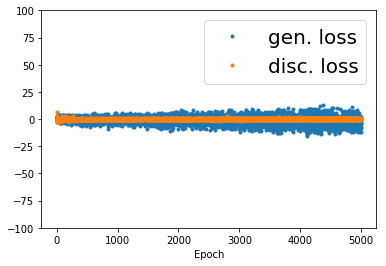

In [35]:
#critic3 - Adam2 - squashed
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')

(-1000, 1000)

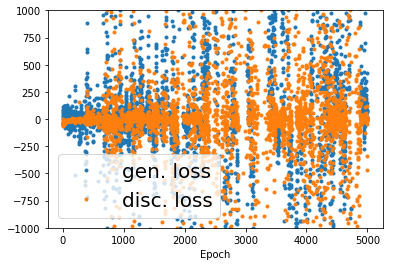

In [71]:
#critic3 - Adam2
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
ylim(-1000, 1000)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

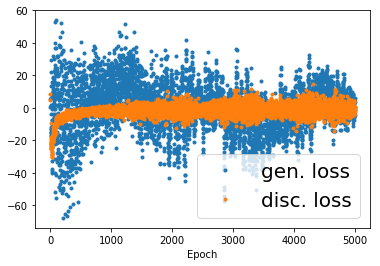

In [58]:
# New critic - Adam2
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

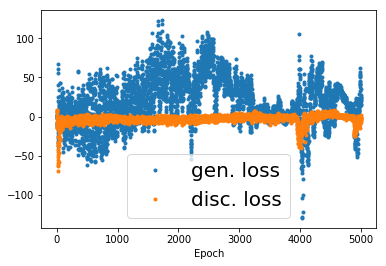

In [47]:
# New critic - Adam
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

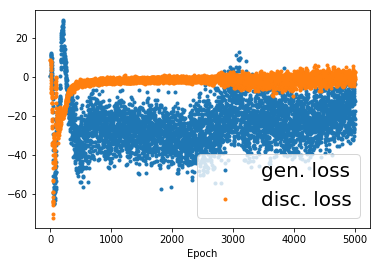

In [37]:
# New critic - RMSprop
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

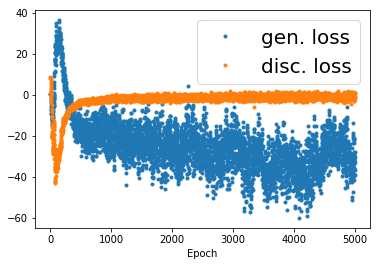

In [37]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

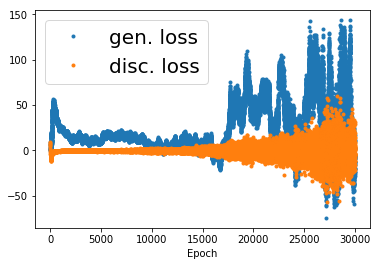

In [107]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

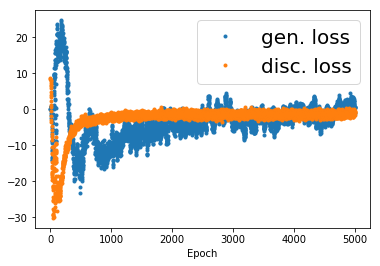

In [77]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

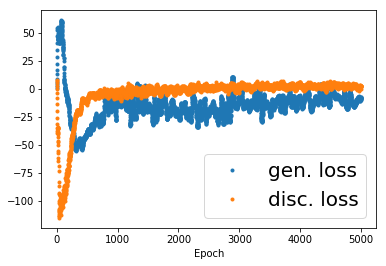

In [61]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

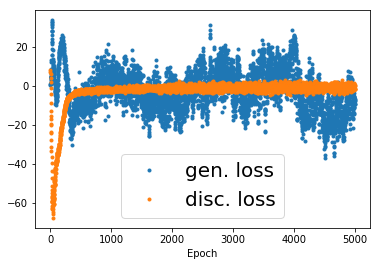

In [48]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

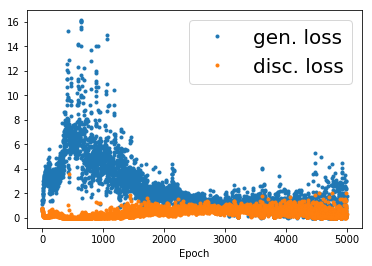

In [33]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

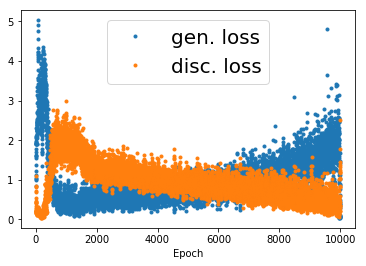

In [13]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

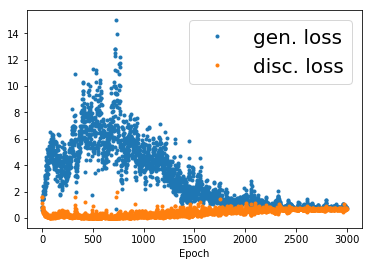

In [111]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

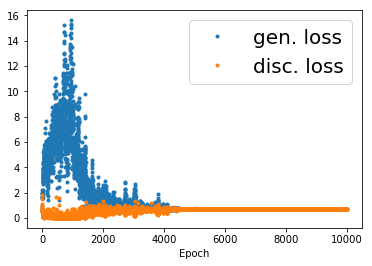

In [102]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

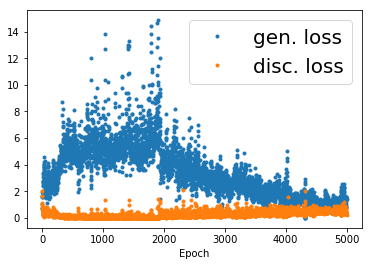

In [218]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

1.0 2.9747797107571028e-18
0.8910042 0.09792483


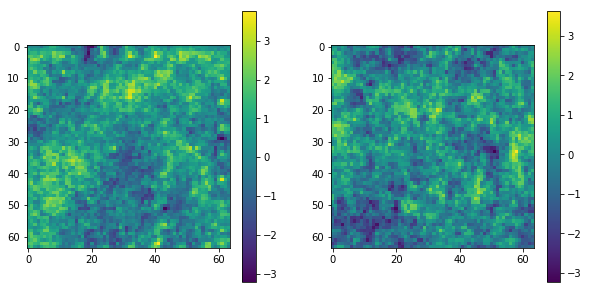

In [21]:
fig = figure(figsize = (10, 5))

test_imgs = []
real_imgs = []
for i in range(128):
    test_imgs.append(generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64))
    real_imgs.append(grf_2d(1.0, alpha=-2.0, normalize=True))
    
test_imgs = np.array(test_imgs)
real_imgs = np.array(real_imgs)

subplot(1,2,1)
imshow(test_imgs[0])
colorbar()
subplot(1,2,2)
imshow(real_imgs[0])
print(np.std(real_imgs.reshape(32, -1), axis=-1).mean(), np.mean(real_imgs.reshape(32, -1), axis=-1).mean())
print(np.std(test_img.reshape(32, -1), axis=-1).mean(), np.mean(test_imgs.reshape(32, -1), axis=-1).mean())
colorbar()

In [22]:
def estimate_pk(kki, img, nbin=30):
    
    bins = np.linspace(np.min(kki), np.max(kki), nbin+1, endpoint=True)

    ibin = [np.logical_and(kki.ravel() >= bins[i], kki.ravel() < bins[i+1]) for i in range(nbin)]
    ibin = np.array(ibin)

    ft = abs(np.fft.fftn(img))**2
    pkk = np.array([np.mean(ft.ravel()[ibin[i]]) for i in range(nbin)])
    kk = np.array([np.mean(kki.ravel()[ibin[i]]) for i in range(nbin)])

    return kk, pkk

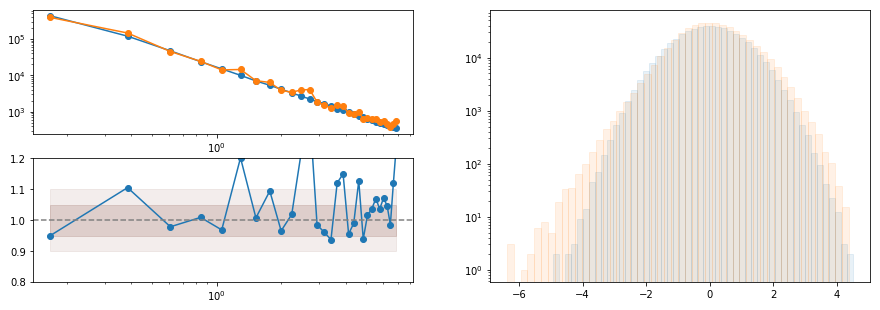

In [23]:
fig = figure(figsize = (15, 5))

kx = np.fft.fftfreq(64, d=0.1)
ky = np.fft.fftfreq(64, d=0.1)
#kz = np.fft.fftfreq(64, d=0.1)
kk = np.sqrt(kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2)

pk1r = []
pk2f = []
for i in range(128):
    k1, pk1 = estimate_pk(kk, real_imgs[i])
    k2, pk2 = estimate_pk(kk, test_imgs[i])

    pk1r.append(pk1)
    pk2f.append(pk2)
pk1r = np.array(pk1r)
pk2f = np.array(pk2f)

subplot(2,2,1)
plot(k1, pk1r.mean(0), '-o')
plot(k2, pk2f.mean(0), '-o')
yscale('log')
xscale('log')
subplot(2,2,3)
plot(k1, np.sqrt(pk2f.mean(0)/pk1r.mean(0)), '-o')
krange = np.linspace(np.min(k1), np.max(k1), 100)
fill_between(krange, np.ones_like(krange)*0.9, np.ones_like(krange)*1.1, color='C5', alpha=0.1)
fill_between(krange, np.ones_like(krange)*0.95, np.ones_like(krange)*1.05, color='C5', alpha=0.2)
axhline(1.0, ls='--', c='grey')
xscale('log')
ylim(0.8, 1.2)

subplot(1,2,2)
foo = hist(real_imgs.ravel(), bins=50, edgecolor='C0', alpha=0.1)
foot = hist(test_imgs.ravel(), bins=50, edgecolor='C1', alpha=0.1)
yscale('log')

In [29]:
hist?

In [53]:
np.min(abs(kx))

0.0

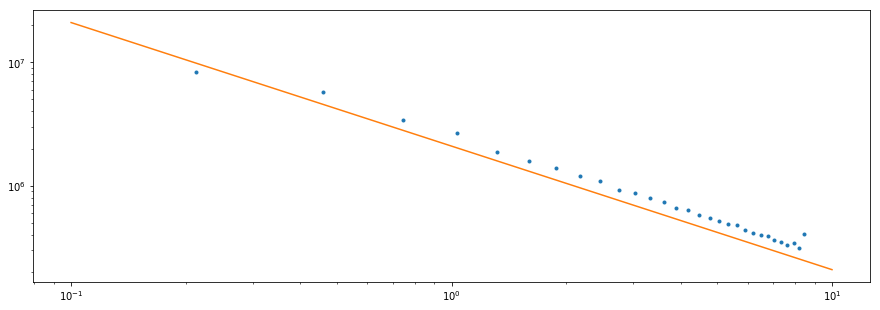

In [49]:
fig = figure(figsize = (15, 5))

kx = np.fft.fftfreq(64, d=0.1)
ky = np.fft.fftfreq(64, d=0.1)
kz = np.fft.fftfreq(64, d=0.1)
kk = np.sqrt(kx[:, np.newaxis, np.newaxis]**2 
             + ky[np.newaxis, :, np.newaxis]**2 
             + kz[np.newaxis, np.newaxis, :]**2)


grf1 = grf_3d(1.0, -1.0, normalize=False)
k1, pk1 = estimate_pk(kk, grf1)

plot(k1, pk1, '.')
krange = np.linspace(0.1, 10, 100)
plot(krange, **3*krange**-1.0)
yscale('log')
xscale('log')


In [47]:
1.0/64**3

3.814697265625e-06

In [46]:
np.mean(grf1), np.std(grf1)

(0.0008564520980637589, 1.5444039939908165)

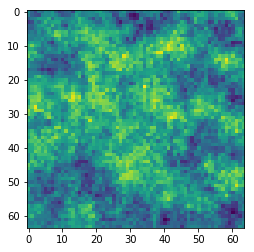

In [25]:
test_img = generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64)

imshow(test_img)

0.0 1.0
0.041711114 1.4031054


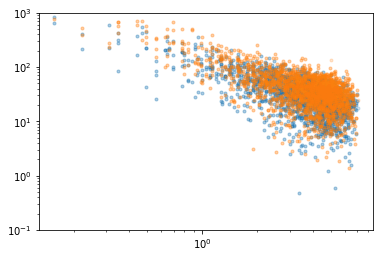

In [26]:
real_sample = grf_2d(1.0, alpha=-2.0)
plot(kk.ravel(), abs(np.fft.fft2(real_sample)).ravel(), '.', alpha=0.2)

plot(kk.ravel(), abs(np.fft.fft2(test_img)).ravel(), '.', alpha=0.2)
yscale('log')
xscale('log')
ylim(1e-1, 1e3)

print(np.mean(real_sample), np.std(real_sample))
print(np.mean(test_img), np.std(test_img))